# Groundwater Data Imputation and Interpolation Script

#####This notebook contains a machine learning algorithm designed to impute data within a set of groundwater wells. The data can then be spatially interpolated to create a groundwater surface raster. Finally, a storage depletion curve can be calculated.

#####It requires as input: 
* an aquifer shapefile
* well locations and observational measurements
* PDSI and GLDAS datasets (link in script)

##### You will also need access to a Google Drive account.



---

<a name="loadUtils"></a>
## **Step 0: Load packages and files**
*This section should be run whenever a new session is started.*

### <font color='dimgray'>Install and load packages and utility files</font>

In [ ]:
#@markdown ### **Run this cell to install the proper packages**
# Creating Environment 1: Spatial (Should handle steps 1-5)
%%capture
!pip install fiona
!pip install rasterio
!pip install h5py
!pip install geopandas
!pip install grids
!pip install scikit-learn
!pip install tables
!pip install pickle5
!pip install gstools
!pip install -U numpy

In [ ]:
#@markdown ### **Run this cell to import all necessary packages to the session**

from google.colab import files, drive
import os
import ipywidgets as widgets
import shutil
import pandas as pd # v1.3.5
import geopandas as gpd
import matplotlib.pyplot as plt
import ee
import numpy as np
import math
import sys
import datetime
import pickle
import netCDF4 as nc
from tqdm import tqdm

In [ ]:
#@markdown ### **Run this cell to import the utility files from Github**

# Importing utility files from github
import requests
sd_url = 'https://raw.githubusercontent.com/Saul-the-engineer/Well_Imputation/master/Master%20Code/utils_01_satellite_data.py'
wf_url = 'https://raw.githubusercontent.com/Saul-the-engineer/Well_Imputation/master/Master%20Code/utils_03_well_data.py'
ml_url = 'https://raw.githubusercontent.com/Saul-the-engineer/Well_Imputation/master/Master%20Code/utils_04_machine_learning.py'
sp_url = 'https://raw.githubusercontent.com/Saul-the-engineer/Well_Imputation/master/Master%20Code/utils_06_spatial.py'
url_set = [sd_url, wf_url, ml_url, sp_url]

# Load the utility files into the session
for url in url_set:
  r = requests.get(url)
  with open(url.rsplit('/', 1)[-1], 'w') as f:
    f.write(r.text)

import utils_01_satellite_data as usd
import utils_03_well_data as wf 
import utils_04_machine_learning
import utils_06_spatial
!mkdir Aquifer_Shapes Aquifers_Data Datasets

/usr/local/lib/python3.7/dist-packages/xarray/backends/cfgrib_.py:28: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  "Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. "


### <font color='dimgray'>Load aquifer shapefile</font>

In [ ]:
#@markdown ### **Run this cell to load the aquifers shapefile**

print("Upload the aquifer shapefile files (including .shp, .shx, .prj, and .dbf):\n")
uploaded = files.upload()
for aqFile in uploaded.keys():
  os.rename('/content/'+aqFile,'/content/Aquifer_Shapes/'+aqFile)

Upload the aquifer shapefile files (including .shp, .shx, .prj, and .dbf):



Saving Escalante_Beryl.cpg to Escalante_Beryl.cpg
Saving Escalante_Beryl.dbf to Escalante_Beryl.dbf
Saving Escalante_Beryl.prj to Escalante_Beryl.prj
Saving Escalante_Beryl.shp to Escalante_Beryl.shp
Saving Escalante_Beryl.shx to Escalante_Beryl.shx


---

## **Table of Contents**
Follow links to jump to specific sections

* [Step 0: Load packages and files](#loadUtils)
* [Step 1: Satellite Data Preparation](#satData)
* [Step 2: Prepare Wells Data for Imputation](#prep)
* [Step 3: Impute Data](#impute)
* [Step 4: Spatial Interpolation](#spatial)
* [Step 5: Storage Depletion Calculation](#storage)

<a name="satData"></a>
## **Step 1: Satellite Data Preparation**

**The PDSI and GLDAS datasets are provided via a shared Google Drive folder, found here:**
https://drive.google.com/drive/folders/1hSN6gkp9zmFYUwMOdDIj8pa-KqBjN8JW?usp=sharing

*You should save a shortcut to your own Google Drive and then determine the file path to the folder.*

In [ ]:
#@markdown ### **Run this cell to mount your Google Drive to access PDSI and GLDAS files**
print("FOLLOW THE URL LINK BELOW\n")
drive.mount('/content/drive')

FOLLOW THE URL LINK BELOW

Mounted at /content/drive


In [ ]:
#@markdown ### **Run the cell and define the path to the Satellite Data * folder ***

def saveText(button):
  global satDataPath
  satDataPath = satDataPath_widget.value
  print('\rPath to Groundwater_Imputation_-_Satellite_Data FOLDER: "%s"' %(satDataPath), end='')

satDataPath_widget = widgets.Text(placeholder='File path to Satellite Data', description='File path:', disabled=False)
button = widgets.Button(description='Save', disabled=False)
button.on_click(saveText)
print('File path to Groundwater_Imputation_-_Satellite_Data folder (not an individual file)\n(e.g. /content/drive/MyDrive/Groundwater_Imputation_-_Satellite_Data)\n\n*Tip: you can navigate to the folder on your Google Drive from the "Files" panel on the left and click on the three dots next to the folder and select "Copy path"\n')
widgets.VBox([satDataPath_widget, button])

File path to Groundwater_Imputation_-_Satellite_Data folder (not an individual file)
(e.g. /content/drive/MyDrive/Groundwater_Imputation_-_Satellite_Data)

*Tip: you can navigate to the folder on your Google Drive from the "Files" panel on the left and click on the three dots next to the folder and select "Copy path"



Path to Groundwater_Imputation_-_Satellite_Data FOLDER: "/content/drive/MyDrive/Groundwater_Imputation_-_Satellite_Data"

### <font color='dimgray'>PDSI Data Prep</font>

In [ ]:
#@markdown ### **Run this cell to parse the PDSI data**

# Purpose of this script is to: 
# 1) Create a grid in the likeness of the netcdf we're interested in querying.
# 2) Using the grid, identify which cells are located within a shape file boundary.
# 3) Use the grids package, and to query the time series, for the variables and cells
#    the user has specified.
# 4) Save data as a pickle file.

# Set data location. If location does not exist, class initialization will create it.
data_root = '/content/Datasets/'
ts_date_start = '1850-01-01'

# Class initialization, imports methods and creates data_root if it doesn't exist.
utils = usd.utils_netCDF(data_root)
# Create grid based on netcdf metadata. Inputs are NE_lat, SW_lat, NE_lon, SW_lon
# x resolution, and y resolution. Calculates the centroids.
grid = utils.netCDF_Grid_Creation(77.5, -60.0, 180.0, -180.0, 2.5, 2.5)
# Loads shape file and obtains bounding box coordinates.
bounds = utils.Shape_Boundary('/content/Aquifer_Shapes/' + aqFile[:-4] + '.shp')
# Loop through grid determining if centroid is within shape boundary. Returns 
# boolean. Hyper-paramters include buffering and padding. Buffer is half cell size
# used to make sure approproate cells are captured.
cell_names = utils.Find_intercepting_cells(grid, bounds)
# Select intercepting cells from dictionary.
mask = utils.Cell_Mask(cell_names, grid)
# Create index from starting date until X weeks from present day.
dates = utils.Date_Index_Creation(ts_date_start)

# The grids_netCDF class is used to handle either the GLDAS or SC PDSI PM dataset
# The file structures are very different. Areas that have missing values, GLDAS
# will treat as NAN, while pdsi treats as mask 'None'. PDSI is a single variable file
# while GLDAS is a multi-variable file per month.

# File_String refers to the data being located with a single string, or list of strings
# Variable String, referes to the variables being within a string or text file.
parse = usd.grids_netCDF(File_String=True, Variable_String=True)

#====================================================================
# Location of single netCDF file.
data_path = satDataPath + '/PDSI/sc_PDSI_pm/pdsi_ramirez_hales_williams_1850-2020.nc4'
#====================================================================

# Name of variables of interest within file.
variables = 'sc_PDSI_pm_filled'

# Parse_Data is a nested loop using the grids python package. For every cell, grabs
# every specified variable. Then parses the variable assigning it to the correct cell
# For PDSI use Mask, dates, data_path, and variable name.

#   Mask: dictionary with locations. 
#   dates: datetimeindex, used to index dataframe
#   data_path: Location of netcdf if it is a single file, else None
#   variable_name: Names of variables wanted parse. 

Data = parse.Parse_Data(mask, dates, data_path = data_path, variable_name=variables)

# Validates that all data exists, removes nans and Nones from time series,
# as well as the location dataframe.
Data = parse.Validate_Data(mask, Data)
#print(Data.keys())
# Final Save.
utils.Save_Pickle(Data,'PDSI_Data', data_root)
print('\nSuccess!')

Starting Cell Selection...
Cells Found.
Loading netCDF location.
Creating Variables
Variable List Made.
Preparing to parse Data.
Working on sc_PDSI_pm_filled 1/1
Parsing Cell_2346 1/2
Parsing Cell_2347 2/2
Validating Data.
Data Validated.

Success!


In [ ]:
#@markdown ### **(Optional) Run this cell to download PDSI pickle files to local machine**
files.download('/content/Datasets/PDSI_Data.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### <font color='dimgray'>GLDAS Data Prep</font>

This step will take 30-60 mins. As such, it is recommended that you set your computer settings to not go to sleep or open a program (e.g. YouTube) that will keep it awake for the full time. The files generated by this step will automatically download so that you can re-upload to your Colab session afterwards.

In [ ]:
#@markdown ### **Run this cell to parse the GLDAS data**

# Purpose of this script is to: 
# 1) Create a grid in the likeness of the netcdf we're interested in querying.
# 2) Using the grid, identify which cells are located within a shape file boundary.
# 3) Use the grids package, and to query the time series, for the variables and cells
#    the user has specified.
# 4) Save data as a pickle file.

# data_root is the location where data will be saved
data_root = '/content/Datasets/'
file_list = satDataPath + '/Sat_Data_Prep_Ref_Files/subset_GLDAS_NOAH025_M_2.0_20210628_013227.txt'

# shape_location is the location to the Shape file
shape_location = '/content/Aquifer_Shapes/' + aqFile[:-4] + '.shp'
# gldas_root is the location of folder containing the tabulated GLDAS
gldas_root = satDataPath + r'/GLDAS_Tabular'

# variables_list_loc the text file containing the GLDAS variable names
variables_list_loc = satDataPath + '/Sat_Data_Prep_Ref_Files/variables_list.txt'

# Class initialization, imports methods and creates data_root if it doesn't exist.
utils = usd.utils_netCDF(data_root)
# Create grid based on netcdf metadata. Inputs are NE_lat, SW_lat, NE_lon, SW_lon
# x resolution, and y resolution. Calculates the centroids.
grid = utils.netCDF_Grid_Creation(89.875, -59.875, 179.875, -179.875, 0.25, 0.25)
# Loads shape file and obtains bounding box coordinates.
bounds = utils.Shape_Boundary(shape_location)

# Loop through grid determining if centroid is within shape boundary. Returns 
# boolean. Hyper-paramters include buffering and padding. Buffer is half cell size
# used to make sure approproate cells are captured.
cell_names = utils.Find_intercepting_cells(grid, bounds)
# Select intercepting cells from dictionary.
mask = utils.Cell_Mask(cell_names, grid)
# Construct list of cell names within shapefile
cell_names = list(cell_names.keys())
# Create GLDAS Parsing class
GLDAS_parse = usd.GLDAS_parse(gldas_root, cell_names)
# Open variable text file, load data, convert to list
variables_list = GLDAS_parse.Variable_List(variables_list_loc)
# Create subset of GLDAS variable columns based on mask
Variable_Dictionary = GLDAS_parse.Open_GLDAS(variables_list, mask)
# Split variables into cells and store them into a dictionary along with location
Data = GLDAS_parse.parse(Variable_Dictionary, mask)
print(Data.keys())

# Save data
utils.Save_Pickle(Data,'GLDAS_Data', data_root)

print('Success!')

Starting Cell Selection...
Cells Found.
Variable List Made.
Parsing Cell_299784 1/6
Parsing Cell_299785 2/6
Parsing Cell_299786 3/6
Parsing Cell_301224 4/6
Parsing Cell_301225 5/6
Parsing Cell_301226 6/6
dict_keys(['Cell_299784', 'Cell_299785', 'Cell_299786', 'Cell_301224', 'Cell_301225', 'Cell_301226', 'Location'])
Success!


In [ ]:
#@markdown ### **(Optional) Run this cell to download GLDAS pickle files to local machine**
files.download('/content/Datasets/GLDAS_Data.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---

<a name="prep"></a>
## **Step 2: Wells Data Preparation**


[Load packages and utility files, if necessary](#loadUtils)

In [ ]:
#@markdown ### **Select pickle option below and run this cell to create/load your pickle file**
#@markdown ##### *Select your pickle creation/upload option below*
Pickle_Upload_Type = "3) Upload existing pickle file from computer" #@param ["1) Create your pickle file", "2) Upload an existing pickle file from Google Drive (recommended for 100+ MB files)", "3) Upload existing pickle file from computer"]
# Load data pickle (it must contain 3 df's: centroid of wells, well locations, well measurements)
if Pickle_Upload_Type[0:1] == '1':
  print('Proceed to next section.')
elif Pickle_Upload_Type[0:1] == '2':
  def saveText(button):
    global pickleFilePath
    pickleFileOriginal = pickleFilePath_widget.value
    pickleFilePath = '/content/Aquifers_Data/' + pickleFileOriginal.rsplit('/', 1)[-1]
    print('\rPickle File: "%s" copied to "%s"' %(pickleFileOriginal, pickleFilePath), end='')
    shutil.copy(pickleFileOriginal, pickleFilePath)
  drive.mount('/content/drive')
  !mkdir Aquifer_Shapes Aquifers_Data Datasets
  pickleFilePath_widget = widgets.Text(placeholder='Path to File', description='File Path:', disabled=False)
  button = widgets.Button(description='Save', disabled=False)
  button.on_click(saveText)
  display(widgets.VBox([pickleFilePath_widget, button]))
else:
  print("Upload the pickle file with well locations, centroid, and time series measurements:\n")
  uploaded = files.upload()
  data_file = ''.join(uploaded)
  os.rename('/content/'+data_file,'/content/Aquifers_Data/'+data_file)
  pickleFilePath = '/content/Aquifers_Data/'+data_file

Upload the pickle file with well locations, centroid, and time series measurements:



Saving Well_Data.pickle to Well_Data.pickle


### <font color='dimgray'>Wells Data - Pickle File Creation (if necessary)</font>
If you need to create a pickle file from csv file(s), this section can be used for preparing a pickle file for wells data preparation. It requires a wells file and a time series file as inputs (.csv files) and creates one output file (.pickle). If you have already uploaded an existing pickle file, you can skip this subsection and go to the 'Wells Data Prep' subsection.

In [ ]:
#@markdown ### **Select upload options and run the cell to create a pickle file from existing csv files**
#@markdown *You can upload a single file, or upload both a wells and a time series file*
upload_a_wells_file = True #@param {type:"boolean"}
upload_a_timeseries_file = True #@param {type:"boolean"}
#@markdown *If a pickle file has already been created, you can skip this section and upload it in the next section (Wells Data Prep)*
if Pickle_Upload_Type[0:1] != '1':
  sys.exit("'Upload pickle file' option selected in last cell. If you need to create your pickle file, return to the last cell and select the appropriate option. Otherwise, proceed to next section.")

def uploadFile(ftype):
  print("Upload your %s csv file\n" %ftype)
  uploaded = files.upload()
  newfile = ''.join(uploaded)
  df = pd.read_csv(newfile)
  return df

def saveHeaders(button):
  global wls_wellID, lat, long, tms_wellID, date, var
  wls_wellID, lat, long, tms_wellID, date, var = wls_wellID_widget.value, lat_widget.value, long_widget.value, tms_wellID_widget.value, date_widget.value, var_widget.value
  print('\rWell ID column (wells file) = "%s", Latitude column = "%s", Longitude column = "%s" Well ID column (time series file) = "%s", Date column = "%s", Variable column = "%s"' %(wls_wellID, lat, long, tms_wellID, date, var), end='')

def Pandas_to_Pickle(combined_df, location_df, centroid, name):
    Aquifer = {'Data':combined_df, 'Location':location_df, 'Centroid':centroid}
    pickle_name = name + '.pickle'
    with open(pickle_name, 'wb') as handle:
        pickle.dump(Aquifer, handle)
    return Aquifer

# Upload csv files and select headers
if upload_a_wells_file == True: wls_df = uploadFile('wells')
if upload_a_timeseries_file == True: tms_df = uploadFile('time series')

if upload_a_wells_file == True: wList = wls_df.columns
else: wList = tms_df.columns
if upload_a_timeseries_file == True: tList = tms_df.columns
else: tList = wls_df.columns

wls_wellID_widget = widgets.Dropdown(options=wList, description = "Well ID")
lat_widget = widgets.Dropdown(options=wList, description = "Latitude")
long_widget = widgets.Dropdown(options=wList, description = "Longitude")
tms_wellID_widget = widgets.Dropdown(options=tList, description = "Well ID")
date_widget = widgets.Dropdown(options=tList, description = "Date")
var_widget = widgets.Dropdown(options=tList, description = "Measurement")
button = widgets.Button(description='Save', disabled=False)
button.on_click(saveHeaders)

print("\n\nSpecify the column headers for your wells and/or time series files and save\n")
wls_grid = widgets.VBox([wls_wellID_widget, lat_widget, long_widget])
tms_grid = widgets.VBox([tms_wellID_widget, date_widget, var_widget])
widgets.GridBox(
     [ widgets.Label(value='Wells File headers:'), wls_grid, 
       widgets.Label(value='Time Series File headers:'), tms_grid, button ], 
     layout=widgets.Layout(grid_template_columns="repeat(4, 300px)")
     )

In [ ]:
#@markdown ### **Define the file name of the pickle file that will be created, then run the cell**
picklefilename = 'CA_JPL' #@param {type:"string"}

# Set the dates as dates and sort in ascending order
tms_df[date] = pd.to_datetime(tms_df[date])
tms_df.sort_values(by=[date], inplace=True)

numWells = len(tms_df.drop_duplicates([tms_wellID]))
numDates = len(tms_df.drop_duplicates([date]))
numDups = len(tms_df.drop_duplicates([tms_wellID, date]))
#print('There are %d unique wells, %d unique dates, and %d unique entries (with a unique well ID and date combo).' % (numWells, numDates, numDups))
#print('The shape of the matrix:' + ' ' + str(tms_df.shape))

# Create the NxM matrix (where N = number of unique dates with values; M = number of unique well IDs)
tms_df_matrix = pd.pivot_table(tms_df, index=date, values=var, columns=tms_wellID)
#print(sum(tms_df_matrix.count()), "values in the matrix\n(Values from the same well and date are averaged)\n")
#print('The shape of the matrix: %s' %str(tms_df_matrix.shape))

# Create locations df
unique_wells_df = wls_df.drop_duplicates(wls_wellID).merge(tms_df.drop_duplicates(tms_wellID)[tms_wellID], left_on=wls_wellID, right_on=tms_wellID)
unique_wells_df.rename(columns={long: "Longitude", lat: "Latitude"}, inplace=True)
unique_wells_df = unique_wells_df[[wls_wellID, 'Latitude', 'Longitude']].set_index(wls_wellID)

# Calculate centroid
centroid_df = pd.DataFrame([0,0], index=(['Longitude','Latitude']))
lonAvg, latAvg = unique_wells_df['Longitude'].mean(), unique_wells_df['Latitude'].mean()
centroid_df.loc['Longitude'], centroid_df.loc['Latitude'] = lonAvg, latAvg

pickleData = Pandas_to_Pickle(tms_df_matrix, unique_wells_df, centroid_df, picklefilename)
pickleFilePath = '/content/Aquifers_Data/'+picklefilename+'.pickle'
os.rename('/content/'+picklefilename+'.pickle', pickleFilePath)

### <font color='dimgray'>Wells Data Prep</font>

In [ ]:
#@markdown ### **Run this cell to filter, resample, and interpolate observed well data**
#@markdown ---
#@markdown #### Specify minimum number of unique observation months
#@markdown *In order to filter out wells that do not have sufficient data, a minimum number of unique observation months (i.e. unique months with at least 1 observation) is required.* **All wells that do not meet this threshold will be discarded.**
Minimum_Observation_Months = 50 #@param {type:"integer"}
#@markdown ---
#@markdown #### Specify the pad size
#@markdown *The pad size determines the length of time (in days) after an observation that data will be interpolated*
Pad_Size = 120 #@param {type:"integer"}
 
# This script opens preprocessed pickle file containing 3 DataFrames: Centroid,
# Well Timeseries, and well location.
# High level does 3 things:
# 1: Extracts Well Time series, and drops any well without a minimum amount
#    of Data within a user specified window
# 2: Interpolates subset of data, removing gaps larger than user specified size
#    Gaps will be filled in using a machine learning algorithm. This step
#    is based on the assumption that groundwater changes are slow, and readings
#    will remain valid for a time period after the original reading.
# 3: Contains support functions of data augmentation such as Rolling-Window 
#    averages and plotting. 

# Data Locations
data_root =    '/content/Datasets/'
aquifer_root = '/content/Aquifers_Data'
figures_root = '/content/Figures Aquifer'

# Location must be added
Wells = wf.wellfunc(data_root, aquifer_root, figures_root)

# read the well data from a pickle file
raw_wells_dict = Wells.read_well_pickle(pickleFilePath.rsplit('/', 1)[-1][:-7])

# extractwelldata extracts waterlevel measurements and creates a pandas data 
# Bcap and Fcap are bottom and final cap, this control guarrenties that wells
# will contain data before and after the caps
# MinEx is the minimum number examples required within dataset
# extract the data into a panda data frame
#@markdown ---
#@markdown #### Specify the imputation window
#@markdown *The imputation window is the period of time we want to impute. The maximum imputation window starts in 1948 and ends in the last year of available data in both satellite datasets.*
Left = 1948 #@param {type:"integer"}
Right = 2021#@param {type:"integer"}
wells_dict = Wells.extractwelldata(raw_wells_dict, Left=Left, Right=Right, Min_Obs_Months=Minimum_Observation_Months, outlier = 3)          

# now need to resample well data to begining of month ('1MS') or chosen period
# next most used will be 'QS' Quarter Start Frequency
# need to fill with NaNs on large gaps
# interpolate the well data to regular interval
# do not interpolate for large gaps (gap size can be set in function)
# provide data on either side of measured data - no nans - can be set in func
# can select data interval in function pad 90, 180, 120
observations_raw = wells_dict['Data']
observations_padded = Wells.interp_well(observations_raw, gap_size = '365 days', pad = Pad_Size, spacing = '1MS')

# Plot Well Results
Wells.well_plot(observations_padded, observations_raw, plot_wells= True)  # plot the data to look at

#Save Datasets
wells_dict['Data'] = observations_padded
wells_dict['Observations'] = observations_raw
Wells.Save_Pickle(wells_dict, 'Well_Data')
observations_raw.to_hdf(data_root + '03_Original_Points.h5', key='df', mode='w')

print('Success!')

In [ ]:
#@markdown ### **(Optional) Run this cell to download the well pickle file and well points h5 file to local machine**
#@markdown ##### *You may have to [allow colab to download multiple files at a time](#download)*
files.download('/content/Datasets/Well_Data.pickle')
files.download('/content/Datasets/03_Original_Points.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---

<a name="impute"></a>

## **Step 3: Data Imputation: Satellite Method With Prior**

This step may take anywhere from a few minutess to a few hours, depending on how many wells you have (that weren't filtered out). The script processes about 2.5 wells per minute.

We recommend that when you run each cell, you also run the optional file download cell at the end of the section so that you don't lose your work.

[Load packages and utility files](#loadUtils)

In [ ]:
#@markdown ### **Run this cell to load a new environment to perform data imputation**
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import utils_04_machine_learning
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.random import set_seed
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
from tensorflow.keras.metrics import RootMeanSquaredError

print('Success!')

Success!


In [ ]:
#@markdown ### **Run this cell to upload files (if starting from a new session)**
Upload_Files = True #@param {type:"boolean"}

if Upload_Files == True:
  if not os.path.isdir('Datasets'):
    !mkdir Datasets
  print("Upload Well_Data pickle file from step 2\n")
  uploaded = files.upload()
  os.rename('/content/'+list(uploaded.keys())[0],'/content/Datasets/'+list(uploaded.keys())[0])
  print("\nUpload 03_Original_Points.h5 file from step 2\n")
  uploaded = files.upload()
  os.rename('/content/'+list(uploaded.keys())[0],'/content/Datasets/'+list(uploaded.keys())[0])
  print("\nUpload PDSI_Data pickle file from step 1\n")
  uploaded = files.upload()
  os.rename('/content/'+list(uploaded.keys())[0],'/content/Datasets/'+list(uploaded.keys())[0])
  print("\nUpload GLDAS_Data pickle file from step 1\n(The file may take several minutes to upload)\n")
  uploaded = files.upload()
  os.rename('/content/'+list(uploaded.keys())[0],'/content/Datasets/'+list(uploaded.keys())[0])
else: print("If your files are not uploaded in the current session, select the Upload_Files box and re-run the cell.")

Upload Well_Data pickle file from step 2



Saving Well_Data.pickle to Well_Data.pickle

Upload 03_Original_Points.h5 file from step 2



Saving 03_Original_Points.h5 to 03_Original_Points.h5

Upload PDSI_Data pickle file from step 1



Saving PDSI_Data.pickle to PDSI_Data.pickle

Upload GLDAS_Data pickle file from step 1
(The file may take several minutes to upload)



Saving GLDAS_Data.pickle to GLDAS_Data.pickle


In [ ]:
warnings.simplefilter(action='ignore')
# Set Seeds to reduce randomness
np.random.seed(42)
set_seed(seed=42)

#Data Settings
#@markdown ### **Define the name of the aquifer, then run the cell**
aquifer_name = "Central Valley, CA" #@param {type:"string"}
data_root =    '/content/Datasets/'
figures_root = '/content/Figures Imputed'
#@markdown ---
#@markdown #### Specify the validation split:
#@markdown *The validation set is part of the training set not used to adjust weights but to prevents overfitting. The larger the validation set is the less likely that overfitting occurs, however there will be fewer examples to train on. A range of 0.10 - 0.35 is recomended, where higher values are used when the wells generally have fewer observed values.*

val_split = 0.30 #@param {type:"number"}
errors = []

# Model Setup
imp = utils_04_machine_learning.imputation(data_root, figures_root)

# Measured Well Data
Well_Data = imp.read_pickle('Well_Data', data_root)
PDSI_Data = imp.read_pickle('PDSI_Data', data_root)
GLDAS_Data = imp.read_pickle('GLDAS_Data', data_root)
Original_Obs_Points = Well_Data['Data']

# Getting Well Dates
Feature_Index = GLDAS_Data[list(GLDAS_Data.keys())[0]].index

# Importing Metrics and Creating Error DataFrame
columns = ['Train ME',     'Train RMSE',      'Train MAE',      'Train Points',      'Train r2',
           'Validation ME','Validation RMSE', 'Validation MAE', 'Validation Points', 'Validation r2',
           'Test ME',      'Test RMSE',       'Test MAE',       'Test Points',       'Test r2',
           'Comp R2']
Summary_Metrics = pd.DataFrame(columns = columns)

# Creating Empty Imputed DataFrame
Imputed_Data = pd.DataFrame(index=Feature_Index)
Model_Output = pd.DataFrame(index=Feature_Index)

In [ ]:
#@markdown ### **Specify your run option and paramters and run this cell to perform data imputation using the machine learning algorithm**
#@markdown #### * *Please note that this step will take a long time. We recommend to [allow Colab to download multiple files at once](#download), then run the subsequent cell at the same time as this cell. That will automatically download your files  after imputation is complete in case your Colab session ends before you return.* *
#@markdown ---
#@markdown #### Specify Model Parameters:
#@markdown *Learning Rate is affects how quickly the model adjust weights*
Learning_Rate = 0.001 #@param {type:"number"} 
#@markdown *Patience is the number of Epochs the model will try after finding a local minima for a better minima.*
Patience =  5 #@param {type:"number"}
#@markdown *Early Stopping is the criteria used to consider if an epoch is a minima.*
Early_stopping_Parameter = 0.0 #@param {type:"number"}
#@markdown *L2 is a parameter for regularization... the higher the value, the more smooth or biased it is*
L2_Parameter = 0.1 #@param {type:"number"} 
# default 0.1

#@markdown ---
#@markdown #### Specify the Number and Size of windows used to build prior features:
#@markdown *The test size parameter specifies the split for the test data and validation dataset (could go up to 0.35 if not many examples)*
windows = [18, 24, 36, 60] #@param

#@markdown ---
#@markdown #### Percentage of data used to build prior features:
#@markdown *Using 100%, 50%, 25%, and 10% respectivly on both sides.*
regression_percent = [1.0, 0.5, 0.25, 0.10] #@param

#@markdown ---
#@markdown #### Number of Folds used in training:
#@markdown *How many splits of the data should be modeled. Increasing this value will significantly increase runtime. Recomended range: 5-10.*
folds = 5 #@param {type:"number"} 


# Starting Learning Loop
loop = tqdm(total = len(Well_Data['Data'].columns), position = 0, leave = False)
for i, well in enumerate(Well_Data['Data']):
    try:
        # Get Well raw readings for single well
        y_raw = Original_Obs_Points[well].fillna(limit=2, method='ffill')
        
        # Get Well readings for single well
        y_well = pd.DataFrame(Well_Data['Data'][well], index = Feature_Index[:])
                
        # Add Dumbies
        table_dumbies = pd.get_dummies(Feature_Index.month_name())
        table_dumbies.index = Feature_Index
        table_dumbies['Months'] = (Feature_Index - Feature_Index[0]).astype(int)
        table_dumbies['Months'] = table_dumbies['Months']/table_dumbies['Months'][-1]
        
        # Create Prior Based on Well Trends
        shift = int(max(windows)/2)
        pchip, x_int_index, pchip_int_index  = imp.interpolate(Feature_Index, y_raw, well, shift = shift)
        prior = imp.linear_extrap(x_int_index, pchip.dropna(), shift, reg_perc = regression_percent, max_sd = 6)
        linear_extrap, extrap_df, extrap_md = prior
        imp.trend_plot(linear_extrap, extrap_df, extrap_md, y_raw, well)
        rw = imp.rolling_windows(linear_extrap, windows = windows)
        rw = rw[rw[rw.columns[-1]].notna()]
        table_rw = pd.DataFrame(rw, index=rw.index, columns = rw.columns)
        imp.rw_plot(y_raw, rw, well, save = True, extension = '.png', show=False)
            
        # PDSI Selection
        (well_x, well_y) = Well_Data['Location'].loc[well]
        well_loc = np.array(([well_x,well_y])).reshape((1,2))
        df_temp = PDSI_Data['Location'].dropna(axis=0).astype(float)
        pdsi_dist = pd.DataFrame(cdist(well_loc, df_temp, metric='euclidean'), columns=df_temp.index).T
        pdsi_key = pdsi_dist[0].idxmin()
        table_pdsi = PDSI_Data[pdsi_key]
                
        # GLDAS Selection
        df_temp = GLDAS_Data['Location'].dropna(axis=0).astype(float)
        gldas_dist = pd.DataFrame(cdist(well_loc, df_temp, metric='euclidean'), columns=df_temp.index).T
        gldas_key = gldas_dist[0].idxmin()
        table_gldas = GLDAS_Data[gldas_key]
        table_gldas = table_gldas[['Psurf_f_inst', 
                            'Wind_f_inst', 
                            'Qair_f_inst', 
                            'Qh_tavg', 
                            'Qsb_acc', 
                            'PotEvap_tavg', 
                            'Tair_f_inst', 
                            'Rainf_tavg',
                            'SoilMoi0_10cm_inst',
                            'SoilMoi10_40cm_inst',
                            'SoilMoi40_100cm_inst',
                            'SoilMoi100_200cm_inst',
                            'CanopInt_inst',
                            'SWE_inst',
                            'Lwnet_tavg',
                            'Swnet_tavg',
                            ]]
        
        # Calculate surface water
        sw_names = ['SoilMoi0_10cm_inst',
                    'SoilMoi10_40cm_inst',
                    'SoilMoi40_100cm_inst',
                    'SoilMoi100_200cm_inst',
                    'CanopInt_inst',
                    'SWE_inst']
        table_sw  = table_gldas[sw_names].sum(axis=1)
        table_sw.name = 'Surface Water'
        
        # Generate additional groundwater features
        gw_names = ['Qsb_acc',
                    'SWE_inst',
                    'Rainf_tavg']
        table_gwf  = table_gldas[gw_names]
        table_gwf['ln(QSB_acc)'] = np.log(table_gwf['Qsb_acc'])
        table_gwf['ln(RW 4 Rainf_tavg)'] = np.log(table_gwf['Rainf_tavg'].rolling(4, min_periods=1).sum())
        table_gwf['Sum Soil Moist'] = (table_sw - table_gldas['CanopInt_inst'] - table_gldas['SWE_inst']).rolling(3, min_periods=1).sum()
        table_gwf = table_gwf.drop(gw_names, axis=1)
        
        # Temporary merging gldas + PDSI before PCA
        Feature_Data = imp.Data_Join(table_pdsi, table_gldas).dropna()
        Feature_Data = imp.Data_Join(Feature_Data, table_rw).dropna()
        Feature_Data = imp.Data_Join(Feature_Data, table_sw).dropna()
        Feature_Data = imp.Data_Join(Feature_Data, table_gwf).dropna()
        Feature_Data = imp.Data_Join(Feature_Data, table_dumbies).dropna()
        
        # Joining Features to Well Data
        Well_set = y_well.join(Feature_Data, how='outer')
        Well_set = Well_set[Well_set[Well_set.columns[1]].notnull()]
        Well_set_clean = Well_set.dropna()
        
        # Split Data into Training/Validation sets
        Y, X = imp.Data_Split(Well_set_clean, well)
        
        # Run feature scaler on feature data, fs, ws for well scaler
        only_scale = windows + [table_sw.name] + table_gwf.columns.to_list()
        no_scale = table_dumbies.columns.to_list()
        fs = StandardScaler()
        ws = StandardScaler()
        
        # Create number of Folds
        (Y_kfold, X_kfold) = (Y.to_numpy(), X.to_numpy())
        kfold = KFold(n_splits = folds, shuffle = False)
        temp_metrics = pd.DataFrame(columns = columns)
        j = 1
        n_epochs = []
        
        # Train K-folds grab error metrics average results
        for train_index, test_index in kfold.split(Y_kfold, X_kfold):
            x_train, x_test = X.iloc[train_index,:], X.iloc[test_index,:]
            y_train, y_test = Y.iloc[train_index], Y.iloc[test_index,:]
            
            # Create validation and training sets
            x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, random_state=42)
            
            x_train, fs = imp.scaler_pipline(x_train, fs, no_scale, train=True)
        
            # Transform validation and test sets
            x_val = imp.scaler_pipline(x_val, fs, no_scale, train=False)
            x_test = imp.scaler_pipline(x_test, fs, no_scale, train=False)
            X_pred_temp = imp.scaler_pipline(Feature_Data, fs, no_scale, train=False)

            
            # Transform Y values
            y_train = pd.DataFrame(ws.fit_transform(y_train), index = y_train.index, columns = y_train.columns)
            y_val = pd.DataFrame(ws.transform(y_val), index = y_val.index, columns = y_val.columns)
            y_test = pd.DataFrame(ws.transform(y_test), index = y_test.index, columns = y_test.columns)
          
            # Model Initialization
            hidden_nodes = 50
            opt = Adam(learning_rate=Learning_Rate)
            model = Sequential()
            model.add(Dense(hidden_nodes, input_dim = x_train.shape[1], activation = 'relu', use_bias=True,
                kernel_initializer='glorot_uniform', kernel_regularizer= L2(l2=L2_Parameter)))
            model.add(Dropout(rate=0.2))
            model.add(Dense(2*hidden_nodes, input_dim = x_train.shape[1], activation = 'relu', use_bias=True,
                kernel_initializer='glorot_uniform'))
            model.add(Dropout(rate=0.2))
            model.add(Dense(1))
            model.compile(optimizer = opt, loss='mse', metrics=[RootMeanSquaredError()])
            
            # Hyper Paramter Adjustments
            early_stopping = callbacks.EarlyStopping(
                                monitor='val_loss', 
                                patience=Patience, 
                                min_delta=Early_stopping_Parameter, 
                                restore_best_weights=True)
            adaptive_lr    = callbacks.ReduceLROnPlateau(
                                monitor='val_loss', 
                                factor=0.1, 
                                min_lr=0)
            history        = model.fit(
                                x_train, 
                                y_train, 
                                epochs=700, 
                                validation_data = (x_val, y_val), 
                                verbose= 0, 
                                callbacks=[early_stopping, adaptive_lr])
            
            # Score and Tracking Metrics
            y_train     = pd.DataFrame(ws.inverse_transform(y_train), index=y_train.index, 
                                      columns = ['Y Train']).sort_index(axis=0, ascending=True)
            y_train_hat = pd.DataFrame(ws.inverse_transform(model.predict(x_train)), index=x_train.index, 
                                      columns = ['Y Train Hat']).sort_index(axis=0, ascending=True)
            y_val       = pd.DataFrame(ws.inverse_transform(y_val), index=y_val.index,
                                       columns = ['Y Val']).sort_index(axis=0, ascending=True)
            y_val_hat   = pd.DataFrame(ws.inverse_transform(model.predict(x_val)), index=x_val.index,
                                       columns = ['Y Val Hat']).sort_index(axis=0, ascending=True)
            
            train_points, val_points = [len(y_train)], [len(y_val)]
            
            train_me    = (sum(y_train_hat.values - y_train.values) / train_points).item()
            train_rmse  = mean_squared_error(y_train.values, y_train_hat.values, squared=False)
            train_mae   = mean_absolute_error(y_train.values, y_train_hat.values)
    
            val_me      = (sum(y_val_hat.values - y_val.values) / val_points).item()
            val_rmse    = mean_squared_error(y_val.values, y_val_hat.values, squared=False)
            val_mae     = mean_absolute_error(y_val.values, y_val_hat.values)
            
            train_e      = [train_me, train_rmse, train_mae]
            val_e        = [val_me, val_rmse, val_mae]
            
            test_cols    = ['Test ME', 'Test RMSE', 'Test MAE']
            
            train_errors = np.array([train_e + val_e]).reshape((1,6))
            errors_col   = ['Train ME','Train RMSE', 'Train MAE',
                            'Validation ME','Validation RMSE', 'Validation MAE']
            df_metrics   = pd.DataFrame(train_errors, index=([str(j)]), columns = errors_col)
            
            df_metrics['Train Points']      = train_points
            df_metrics['Validation Points'] = val_points
            df_metrics['Train r2'], _       = pearsonr(y_train.values.flatten(), y_train_hat.values.flatten())
            df_metrics['Validation r2'], _  = pearsonr(y_val.values.flatten(), y_val_hat.values.flatten())
            temp_metrics = pd.concat(objs=[temp_metrics, df_metrics])
            
            # Model Prediction
            Prediction_temp = pd.DataFrame(
                            ws.inverse_transform(model.predict(X_pred_temp)), 
                            index=X_pred_temp.index, columns = ['Prediction'])
            
            # Test Sets and Plots
            try:
                y_test       = pd.DataFrame(ws.inverse_transform(y_test), index=y_test.index,
                                   columns = ['Y Test']).sort_index(axis=0, ascending=True)
                y_test_hat   = pd.DataFrame(ws.inverse_transform(model.predict(x_test)), index=y_test.index, 
                                   columns = ['Y Test Hat']).sort_index(axis=0, ascending=True)
                test_points  = len(y_test)
                test_me      = (sum(y_test_hat.values - y_test.values) / test_points).item()
                test_rmse    = mean_squared_error(y_test.values, y_test_hat.values, squared=False)
                test_mae     = mean_absolute_error(y_test.values, y_test_hat.values)
                            
                test_errors  = np.array([test_me, test_rmse, test_mae]).reshape((1,3))
                test_cols    = ['Test ME', 'Test RMSE', 'Test MAE']
                test_metrics = pd.DataFrame(test_errors,
                                            index = [str(j)], 
                                            columns = test_cols)
                test_metrics['Test Points'] = test_points
                test_metrics['Test r2'], _  = pearsonr(y_test.values.flatten(), y_test_hat.values.flatten())
                temp_metrics.loc[str(j), test_metrics.columns] = test_metrics.loc[str(j)]
                plot_kfolds = True
                imp.prediction_kfold(Prediction_temp['Prediction'], 
                                              y_well.drop(y_test.index, axis=0),  
                                              y_test, 
                                              str(well) +"_kfold_" + str(j), 
                                              temp_metrics.loc[str(j)], 
                                              error_on = True,
                                              plot = plot_kfolds)

            except: 
                temp_metrics.loc[str(j), ['Test ME','Test RMSE', 'Test MAE']] = np.NAN
                temp_metrics.loc[str(j), 'Test Points'] = 0 
                temp_metrics.loc[str(j),'Test r2'] = np.NAN
                imp.prediction_kfold(Prediction_temp['Prediction'], 
                                        y_well.drop(y_test.index, axis=0),
                                        y_test, 
                                        str(well) +"_kfold_" + str(j),
                                        plot = plot_kfolds)
            j += 1
            n_epochs.append(len(history.history['loss']))
            
        epochs = int(sum(n_epochs)/folds)
        
        # Reset feature scalers
        X, fs  = imp.scaler_pipline(X, fs, no_scale, train=True)
        X_pred = imp.scaler_pipline(Feature_Data, fs, no_scale, train=False)
        Y = pd.DataFrame(ws.fit_transform(Y), index = Y.index, columns = Y.columns)
        
        # Retrain Model with number of epochs
        history = model.fit(X, Y, epochs = epochs, verbose = 0)
        metrics_avg = pd.DataFrame(temp_metrics.mean(), columns=[well]).transpose()
        Summary_Metrics = pd.concat(objs=[Summary_Metrics, metrics_avg])
        
        # Model Prediction
        Prediction = pd.DataFrame(
                        ws.inverse_transform(model.predict(X_pred)), 
                        index=X_pred.index, columns = [well])
        
        Comp_R2    = r2_score(
                        ws.inverse_transform(Y.values.reshape(-1,1)), 
                        ws.inverse_transform(model.predict(X)))
        Summary_Metrics.loc[well,'Comp R2'] = Comp_R2

        # Data Filling
        Gap_time_series = pd.DataFrame(Well_Data['Data'][well], index = Prediction.index)
        Filled_time_series = Gap_time_series[well].fillna(Prediction[well])
        if y_raw.dropna().index[-1] > Prediction.index[-1]:
            Filled_time_series = pd.concat([Filled_time_series, y_raw.dropna()], join='outer', axis=1)
            Filled_time_series = Filled_time_series.iloc[:,0]
            Filled_time_series = Filled_time_series.fillna(y_raw)
        Imputed_Data = pd.concat([Imputed_Data, Filled_time_series], join='outer', axis=1)
        Model_Output = pd.concat([Model_Output, Prediction], join='outer', axis=1)
                
        # Model Plots
        imp.prediction_vs_test_kfold(Prediction[well], y_well, str(well), Summary_Metrics.loc[well], error_on = True)
        imp.raw_observation_vs_prediction(Prediction[well], y_raw, str(well), aquifer_name, Summary_Metrics.loc[well], error_on = True, test=True)
        imp.raw_observation_vs_filled(Filled_time_series, y_raw, str(well), aquifer_name, Summary_Metrics.loc[well], error_on = True, test=True) 
        imp.residual_plot(Prediction.index, Prediction[well], y_well.index, y_well, str(well))
        imp.Model_Training_Metrics_plot(history.history, str(well))
        loop.update(1)
    except Exception as e:
        errors.append((i, e))
        imp.log_errors(errors, 'errors', data_root)

loop.close()
Well_Data['Data'] = Imputed_Data.loc[Prediction.index]
Well_Data['Raw_Output'] = Model_Output.loc[Prediction.index]
Well_Data['Metrics'] = Summary_Metrics
Well_Data['Data_Smooth'] = imp.smooth(Imputed_Data.loc[Prediction.index], Well_Data['Data'], window = 18)
Summary_Metrics.to_csv(data_root  + '/' + '06_Metrics.csv', index=True)
imp.Save_Pickle(Well_Data, 'Well_Data_Imputed', data_root)
imp.Save_Pickle(Imputed_Data, 'Well_Data_Imputed_Raw', data_root)
imp.Aquifer_Plot(Well_Data['Data'])
print('Success!')

<a name="impute"></a>

## **Step 4: Data Imputation: Iterative Refinement**

This step may take anywhere from a few minutess to a few hours, depending on how many wells you have (that weren't filtered out). The script processes about 2.5 wells per minute.

We recommend that when you run each cell, you also run the optional file download cell at the end of the section so that you don't lose your work.

[Load packages and utility files](#loadUtils)

In [ ]:
#@markdown ### **Run this cell to upload satellite imputation pickle file (if starting from a new session)**
Upload_Files = True #@param {type:"boolean"}

if Upload_Files == True:
  if not os.path.isdir('Datasets'):
    !mkdir Datasets
    
  print("Upload Well_Data pickle file from step 2\n")
  uploaded = files.upload()
  os.rename('/content/'+list(uploaded.keys())[0],'/content/Datasets/'+list(uploaded.keys())[0])

  print("Upload Well_Data_Imputed pickle file from step 3\n")
  uploaded = files.upload()
  os.rename('/content/'+list(uploaded.keys())[0],'/content/Datasets/'+list(uploaded.keys())[0])
else: print("If your files are not uploaded in the current session, select the Upload_Files box and re-run the cell.")

Upload Well_Data pickle file from step 2



Saving Well_Data.pickle to Well_Data.pickle
Upload Well_Data_Imputed pickle file from step 3



Saving Well_Data_Imputed.pickle to Well_Data_Imputed.pickle


In [ ]:
#@markdown ### **Run this cell to load environment to perform iterative refinement**
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd #1.3.5
import numpy as np
import math
import utils_04_machine_learning
from scipy.stats import pearsonr
from scipy.spatial.distance import cdist
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_selection import r_regression #1.1.2
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.random import set_seed
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
from tensorflow.keras.metrics import RootMeanSquaredError

print('Success!')

Success!


In [ ]:
#@markdown ### **Check box and run cell to perform iterative refinement**
#@markdown ##### This method uses geospatial correlations between wells to correct the well imputations.
run_iterative_method = True #@param {type:"boolean"}
if run_iterative_method == False: 
  raise SystemExit("run_iterative_method variable set to False. If you do not wish to run the iterative algorithm, continue to next cell.")
#Data Settings
#@markdown ### **Define the name of the aquifer, then run the cell**
aquifer_name = "Central Valley, CA" #@param {type:"string"}
data_root =    '/content/Datasets/'
figures_root = '/content/Figures Imputed'
#@markdown ---
#@markdown #### Specify the validation split:
#@markdown *The validation set is part of the training set not used to adjust weights but to prevents overfitting. The larger the validation set is the less likely that overfitting occurs, however there will be fewer examples to train on. A range of 0.10 - 0.35 is recomended, where higher values are used when the wells generally have fewer observed values.*

val_split = 0.30 #@param {type:"number"}
errors = []

#@markdown ---
#@markdown *Number of iterations used in refinement*
iterations =  2#@param (type:"integer")
#@markdown *Correlation Weight: Higher (0.90 - 0.95) for small aquifers, smaller (0.70 - 0.80) for large aquifers*
weight_cor = 0.90 #@param (type:"integer")
weight_dist = 1 - weight_cor
min_features = 5#@param (type:"integer")
feature_thresh = 0.6 

#@markdown #### Specify Model Parameters:
#@markdown *Learning Rate is affects how quickly the model adjust weights*
Learning_Rate = 0.001 #@param {type:"number"} 
#@markdown *Patience is the number of Epochs the model will try after finding a local minima for a better minima.*
Patience =  5 #@param {type:"number"}
#@markdown *Early Stopping is the criteria used to consider if an epoch is a minima.*
Early_stopping_Parameter = 0.0 #@param {type:"number"}
#@markdown *L2 is a parameter for regularization... the higher the value, the more smooth or biased it is*
L2_Parameter = 0.1 #@param {type:"number"} 

#@markdown #### Specify the Number and Size of windows used to build prior features:
#@markdown *The test size parameter specifies the split for the test data and validation dataset (could go up to 0.35 if not many examples)*
windows = [24] #@param
regression_percent = [1.0, 0.5, 0.25, 0.10] #@param

#@markdown ---
#@markdown #### Number of Folds used in training:
#@markdown *How many splits of the data should be modeled. Increasing this value will significantly increase runtime. Recomended range: 5-10.*
folds = 5 #@param {type:"number"}


errors = []

for iteration in range(0, iterations):
    # Print Iteration, Set up Figures, Create model class
    print(f'Starting iteration: {iteration+1}/{iterations}.')
    figures_root = f'./Wells Imputed_iteration_{iteration+1}'
    imp = utils_04_machine_learning.imputation(data_root, figures_root)


    # Measured Well Data
    Well_Data = imp.read_pickle('Well_Data', data_root)
    Original_Obs_Points = Well_Data['Data']
    if iteration == 0: Well_Data_Pretrained = imp.read_pickle('Well_Data_Imputed', data_root)
    else: Well_Data_Pretrained = imp.read_pickle(f'Well_Data_Imputed_iteration_{iteration-1}', data_root)
    
    # Replace data from 3 std, perhaps look at replace where change between points
    temp_data = Well_Data_Pretrained['Data']
    temp_columns = Well_Data_Pretrained['Data'].columns.to_list()
    Well_Data_Pretrained['Data'] = imp.hampel_filter(temp_data, Well_Data['Data'], max_sd = 3, window = 36)

    # Getting Well Dates
    Feature_Index = Well_Data_Pretrained['Data'].index
    
    # Importing Metrics and Creating Error DataFrame
    columns = ['Train ME',     'Train RMSE',      'Train MAE',      'Train Points',      'Train r2',
               'Validation ME','Validation RMSE', 'Validation MAE', 'Validation Points', 'Validation r2',
               'Test ME',      'Test RMSE',       'Test MAE',       'Test Points',       'Test r2',
               'Comp R2']
    Summary_Metrics = pd.DataFrame(columns = columns)
    
    # Feature importance Tracker
    Feature_Importance = pd.DataFrame()
    
    # Creating Empty Imputed DataFrame
    Imputed_Data = pd.DataFrame(index=Feature_Index)
    Model_Output = pd.DataFrame(index=Feature_Index)
    Feature_Correlation = pd.DataFrame(index=Well_Data['Data'].columns, columns = ['FI', 'WI'])
    
    loop = tqdm(total = len(Well_Data['Data'].columns), position = 0, leave = False)
    for i, well in enumerate(Well_Data['Data']):
        try:
            # Get Well raw readings for single well
            y_raw = Original_Obs_Points[well].fillna(limit=2, method='ffill')
            
            # Get Well readings for single well
            y_well = pd.DataFrame(Well_Data['Data'][well], index = Feature_Index[:])

            # Add Dumbies
            table_dumbies = pd.get_dummies(Feature_Index.month_name())
            table_dumbies.index = Feature_Index
            table_dumbies['Months'] = (Feature_Index - Feature_Index[0]).astype(int)
            table_dumbies['Months'] = table_dumbies['Months']/table_dumbies['Months'][-1]
            
            # Create Well Trend
            windows = [24]
            shift = int(max(windows)/2)
            pchip, x_int_index, pchip_int_index  = imp.interpolate(Feature_Index, y_raw, well, shift = shift)
            temp = imp.linear_extrap(x_int_index, pchip.dropna(), shift, reg_perc = regression_percent, max_sd = 6)
            linear_extrap, extrap_df, extrap_md = temp
            imp.trend_plot(linear_extrap, extrap_df, extrap_md, y_raw, well)
            rw = imp.rolling_windows(linear_extrap, windows = windows)
            rw = rw[rw[rw.columns[-1]].notna()]
            table_rw = pd.DataFrame(rw, index=rw.index, columns = rw.columns)
            imp.rw_plot(y_raw, rw, well, save = True, extension = '.png', show=False)

            # Load Pretrained Data Drop current Column
            Feature_Data = Well_Data_Pretrained['Data'].drop(well, axis=1)
            
            # Calculate Pearsons Correlation Value
            fs_data = imp.Data_Join(Feature_Data, y_well).dropna()
            pearsons_r = r_regression(fs_data.drop(well, axis=1), fs_data[well])
            pearsons_r = pd.DataFrame(pearsons_r.T, index=Feature_Data.columns, columns=['r'])
            
            # Calculate normalized distance
            (well_x, well_y) = Well_Data['Location'].loc[well]
            well_loc = np.array(([well_x,well_y])).reshape((1,2))
            feature_loc = Well_Data['Location'].drop(well, axis=0)
            dist = pd.DataFrame(cdist(well_loc, feature_loc, metric='euclidean'), columns=feature_loc.index, index=['dist']).T
            dist = 1 - (dist/dist.max())
            
            # Calculate weighed score
            fs_data = imp.Data_Join(pearsons_r, dist).dropna()
            fs_data['w_score'] = fs_data['r'] * weight_cor + fs_data['dist'] * weight_dist
            fs_data.sort_values(by=['w_score'], axis=0, ascending=False, inplace=True)
                        
            # Calculate number of Features
            fs_name = fs_data.index.to_list()
            fs_data_score = fs_data.loc[fs_name[0:min_features]]['w_score'].mean()
            fs_data_score = math.floor(fs_data_score*10)/10
            if feature_thresh - fs_data_score <= 0: add_features = 0
            else: add_features = int((feature_thresh - fs_data_score) * 10)
            num_features = min_features + add_features
            
            # Select Features
            fs_name = fs_name[0:num_features]
            Feature_Data = Feature_Data[fs_name]
            
            # Calculate correlation metrics
            feature_temp = pd.concat([y_well, Feature_Data], axis=1, join='outer')
            imp.feature_plot(feature_temp, Well_Data['Data'], well)
            Feature_Correlation = imp.feature_correlation(Feature_Correlation, feature_temp, Well_Data['Data'], fs_data.loc[fs_name])
            
            # Join Best features with Rolling Windows
            Feature_Data = imp.Data_Join(Feature_Data, table_rw).dropna()
            
            # Joining Features to Well Data
            Well_set = y_well.join(Feature_Data, how='outer')
            Well_set = Well_set[Well_set[Well_set.columns[1]].notnull()]
            Well_set_clean = Well_set.dropna()
            
            # Feature Split
            Y, X = imp.Data_Split(Well_set_clean, well)
            
            # Initialize scalers
            fs = StandardScaler()
            ws = StandardScaler()
            
            # Create number of Folds
            (Y_kfold, X_kfold) = (Y.to_numpy(), X.to_numpy())
            kfold = KFold(n_splits = folds, shuffle = False)
            temp_metrics = pd.DataFrame(columns = columns)
            j = 1
            n_epochs = []
            
            # Train K-folds grab error metrics average results
            for train_index, test_index in kfold.split(Y_kfold, X_kfold):
                x_train, x_test = X.iloc[train_index,:], X.iloc[test_index,:]
                y_train, y_test = Y.iloc[train_index], Y.iloc[test_index,:]
                
                # Create validation and training sets
                x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, random_state=42)
                
                # Transform feature data
                x_train = pd.DataFrame(fs.fit_transform(x_train), index = x_train.index, columns = x_train.columns)
                x_train = imp.Data_Join(x_train, table_dumbies, method='inner')
                        
                # Feature scaling and joining of dumbie variables for validation, test, prediction
                x_val = pd.DataFrame(fs.transform(x_val), index = x_val.index, columns = x_val.columns)
                x_val = imp.Data_Join(x_val, table_dumbies, method='inner')
                            
                x_test = pd.DataFrame(fs.transform(x_test), index = x_test.index, columns = x_test.columns)
                x_test = imp.Data_Join(x_test, table_dumbies, method='inner')
                
                X_pred_temp = pd.DataFrame(fs.transform(Feature_Data), index = Feature_Data.index, columns = Feature_Data.columns)
                X_pred_temp = imp.Data_Join(X_pred_temp, table_dumbies, method='inner')
                
                # Transform Y values
                y_train = pd.DataFrame(ws.fit_transform(y_train), index = y_train.index, columns = y_train.columns)
                y_val = pd.DataFrame(ws.transform(y_val), index = y_val.index, columns = y_val.columns)
                y_test = pd.DataFrame(ws.transform(y_test), index = y_test.index, columns = y_test.columns)
                                
                # Model Initialization
                hidden_nodes = 50
                opt = Adam(learning_rate=Learning_Rate)
                model = Sequential()
                model.add(Dense(hidden_nodes, input_dim = x_train.shape[1], activation = 'relu', use_bias=True,
                    kernel_initializer='glorot_uniform', kernel_regularizer= L2(l2=L2_Parameter)))
                model.add(Dropout(rate=0.2))
                model.add(Dense(2*hidden_nodes, input_dim = x_train.shape[1], activation = 'relu', use_bias=True,
                    kernel_initializer='glorot_uniform'))
                model.add(Dropout(rate=0.2))
                model.add(Dense(1))
                model.compile(optimizer = opt, loss='mse', metrics=[RootMeanSquaredError()])
                
                # Hyper Paramter Adjustments
                early_stopping = callbacks.EarlyStopping(
                                    monitor='val_loss', 
                                    patience=Patience, 
                                    min_delta=Early_stopping_Parameter, 
                                    restore_best_weights=True)
                adaptive_lr    = callbacks.ReduceLROnPlateau(
                                    monitor='val_loss', 
                                    factor=0.1, 
                                    min_lr=0)
                history        = model.fit(
                                    x_train, 
                                    y_train, 
                                    epochs=700, 
                                    validation_data = (x_val, y_val), 
                                    verbose= 0, 
                                    callbacks=[early_stopping, adaptive_lr])
                               
                # Score and Tracking Metrics
                y_train     = pd.DataFrame(ws.inverse_transform(y_train), index=y_train.index, 
                                          columns = ['Y Train']).sort_index(axis=0, ascending=True)
                y_train_hat = pd.DataFrame(ws.inverse_transform(model.predict(x_train)), index=x_train.index, 
                                          columns = ['Y Train Hat']).sort_index(axis=0, ascending=True)
                y_val       = pd.DataFrame(ws.inverse_transform(y_val), index=y_val.index,
                                           columns = ['Y Val']).sort_index(axis=0, ascending=True)
                y_val_hat   = pd.DataFrame(ws.inverse_transform(model.predict(x_val)), index=x_val.index,
                                           columns = ['Y Val Hat']).sort_index(axis=0, ascending=True)
                
                train_points, val_points = [len(y_train)], [len(y_val)]
                
                train_me    = (sum(y_train.values - y_train_hat.values) / train_points).item()
                train_rmse  = mean_squared_error(y_train.values, y_train_hat.values, squared=False)
                train_mae   = mean_absolute_error(y_train.values, y_train_hat.values)
        
                val_me      = (sum(y_val.values - y_val_hat.values) / val_points).item()
                val_rmse    = mean_squared_error(y_val.values, y_val_hat.values, squared=False)
                val_mae     = mean_absolute_error(y_val.values, y_val_hat.values)
                
                train_e      = [train_me, train_rmse, train_mae]
                val_e        = [val_me, val_rmse, val_mae]
                
                test_cols    = ['Test ME', 'Test RMSE', 'Test MAE']
                
                train_errors = np.array([train_e + val_e]).reshape((1,6))
                errors_col   = ['Train ME','Train RMSE', 'Train MAE',
                                'Validation ME','Validation RMSE', 'Validation MAE']
                df_metrics   = pd.DataFrame(train_errors, index=([str(j)]), columns = errors_col)
                
                df_metrics['Train Points']      = train_points
                df_metrics['Validation Points'] = val_points
                df_metrics['Train r2'], _       = pearsonr(y_train.values.flatten(), y_train_hat.values.flatten())
                df_metrics['Validation r2'], _  = pearsonr(y_val.values.flatten(), y_val_hat.values.flatten())
                temp_metrics = pd.concat(objs=[temp_metrics, df_metrics])
                
                # Model Prediction
                Prediction_temp = pd.DataFrame(
                            ws.inverse_transform(model.predict(X_pred_temp)), 
                            index=X_pred_temp.index, columns = ['Prediction'])
                
                # Test Sets and Plots
                try:
                    y_test       = pd.DataFrame(ws.inverse_transform(y_test), index=y_test.index,
                                       columns = ['Y Test']).sort_index(axis=0, ascending=True)
                    y_test_hat   = pd.DataFrame(ws.inverse_transform(model.predict(x_test)), index=y_test.index, 
                                       columns = ['Y Test Hat']).sort_index(axis=0, ascending=True)
                    test_points  = len(y_test)
                    test_me      = (sum(y_test.values - y_test_hat.values) / test_points).item()
                    test_rmse    = mean_squared_error(y_test.values, y_test_hat.values, squared=False)
                    test_mae     = mean_absolute_error(y_test.values, y_test_hat.values)
                                
                    test_errors  = np.array([test_me, test_rmse, test_mae]).reshape((1,3))
                    test_cols    = ['Test ME', 'Test RMSE', 'Test MAE']
                    test_metrics = pd.DataFrame(test_errors,
                                                index = [str(j)], 
                                                columns = test_cols)
                    test_metrics['Test Points'] = test_points
                    test_metrics['Test r2'], _  = pearsonr(y_test.values.flatten(), y_test_hat.values.flatten())
                    temp_metrics.loc[str(j), test_metrics.columns] = test_metrics.loc[str(j)]
                    plot_kfolds = True
                    imp.prediction_kfold(Prediction_temp['Prediction'], 
                                              y_well.drop(y_test.index, axis=0),  
                                              y_test, 
                                              str(well) +"_kfold_" + str(j), 
                                              temp_metrics.loc[str(j)], 
                                              error_on = True,
                                              plot = plot_kfolds)
    
                except: 
                    temp_metrics.loc[str(j), ['Test ME','Test RMSE', 'Test MAE']] = np.NAN
                    temp_metrics.loc[str(j), 'Test Points'] = 0 
                    temp_metrics.loc[str(j),'Test r2'] = np.NAN
                    imp.prediction_kfold(Prediction_temp['Prediction'], 
                                        y_well.drop(y_test.index, axis=0),
                                        y_test, 
                                        str(well) +"_kfold_" + str(j),
                                        plot = plot_kfolds)
                j += 1
                n_epochs.append(len(history.history['loss']))
            
            epochs = int(sum(n_epochs)/folds)
            
            X = pd.DataFrame(fs.transform(X), index = X.index, columns = X.columns)
            X = imp.Data_Join(X, table_dumbies, method='inner')
            
            X_pred = pd.DataFrame(fs.transform(Feature_Data), index = Feature_Data.index, columns = Feature_Data.columns)
            X_pred = imp.Data_Join(X_pred, table_dumbies, method='inner')
            
            Y = pd.DataFrame(ws.transform(Y), index = Y.index, columns = Y.columns)
                    
            # Retrain Model with number of epochs
            history = model.fit(X, Y, epochs = epochs, verbose = 0)
            metrics_avg = pd.DataFrame(temp_metrics.mean(), columns=[well]).transpose()
            Summary_Metrics = pd.concat(objs=[Summary_Metrics, metrics_avg])

            # Model Prediction
            Prediction = pd.DataFrame(
                            ws.inverse_transform(model.predict(X_pred)), 
                            index=X_pred.index, columns = [well])
            
            Comp_R2    = r2_score(
                            ws.inverse_transform(Y.values.reshape(-1,1)), 
                            ws.inverse_transform(model.predict(X)))
            Summary_Metrics.loc[well,'Comp R2'] = Comp_R2
            
            # Data Filling
            Gap_time_series = pd.DataFrame(Well_Data['Data'][well], index = Prediction.index)
            Filled_time_series = Gap_time_series[well].fillna(Prediction[well])
            if y_raw.dropna().index[-1] > Prediction.index[-1]:
                Filled_time_series = pd.concat([Filled_time_series, y_raw.dropna()], join='outer', axis=1)
                Filled_time_series = Filled_time_series.iloc[:,0]
                Filled_time_series = Filled_time_series.fillna(y_raw)
            Imputed_Data = pd.concat([Imputed_Data, Filled_time_series], join='outer', axis=1)
            Model_Output = pd.concat([Model_Output, Prediction], join='outer', axis=1)
    
            # Model Plots
            imp.prediction_vs_test_kfold(Prediction[well], y_well, str(well), Summary_Metrics.loc[well], error_on = True)
            imp.raw_observation_vs_prediction(Filled_time_series, y_raw, str(well), aquifer_name, Summary_Metrics.loc[well], error_on = True, test=True) 
            imp.residual_plot(Prediction.index, Prediction[well], y_well.index, y_well, str(well))
            imp.Model_Training_Metrics_plot(history.history, str(well))
            loop.update(1)
        except Exception as e:
            errors.append((i, e))
            imp.log_errors(errors, 'errors', data_root)
    
    loop.close()
    Well_Data['Feature Correlation'] = Feature_Correlation   
    Well_Data['Data'] = Imputed_Data.loc[Prediction.index]
    Well_Data['Raw_Output'] = Model_Output.loc[Prediction.index]
    Well_Data['Metrics'] = Summary_Metrics
    Well_Data['Data_Smooth'] = imp.smooth(Imputed_Data.loc[Prediction.index], Well_Data['Data'], window = 18)
    Summary_Metrics.to_csv(data_root  + '/' + f'06-{iteration}_Metrics.csv', index=True)
    imp.Save_Pickle(Well_Data, f'Well_Data_Imputed_iteration_{iteration}', data_root)
    imp.Save_Pickle(Imputed_Data, f'Well_Data_Imputed_Raw_{iteration}', data_root)
    imp.Aquifer_Plot(Well_Data['Data']) 

In [ ]:
#@markdown ### **(Optional) Run this cell to download the imputed well data pickle file and the error metrics h5 file to local machine**
#@markdown ##### *You may have to [allow colab to download multiple files at a time](#download)*
files.download('/content/Datasets/Well_Data_Imputed.pickle')
files.download('/content/Datasets/06_Metrics.h5')

In [ ]:
from PIL import Image, ImageDraw
#@markdown ### **(Optional) Check the box and run the cell to create a pdf of the plots**
savePDF = False #@param {type:"boolean"}
if savePDF == True:
  #@markdown ##### Specify the parameters used (this will be printed on the first page of the pdf)
  params = "" #@param {type:"string"}
  imgList = []
  for filename in os.listdir('Figures Imputed'):
    image = Image.open('Figures Imputed/' + filename)
    img = image.convert('RGB')
    imgList.append(img)
  img = Image.new('RGB', (500, 100), color = (255, 255, 255))
  d = ImageDraw.Draw(img).text((10,10), "DATA IMPUTATION FIGURES\n"+aquifer_name+"\nParams = "+params, fill=(0, 0, 0))
  img.save(r'Imputed_Figures.pdf',save_all=True, append_images=imgList)
  files.download('/content/Imputed_Figures.pdf')

---

<a name="spatial"></a>
## **Step 4: Spatial Interpolation**

[Load packages and utility files, if necessary](#loadUtils)

[Load aquifer shapefile, if necessary](#loadFiles)



In [ ]:
#@markdown ### **Run this cell to upload imputed data file (if starting from a new session)**
Upload_Files = True #@param {type:"boolean"}

if Upload_Files == True:
  if not os.path.isdir('Datasets'): 
    !mkdir Datasets
  print("Upload Well_Data_Imputed pickle file from step 3, or step 4\n")
  uploaded = files.upload()
  os.rename('/content/'+list(uploaded.keys())[0],'/content/Datasets/Well_Data_Imputed.pickle')
else: print("If your files are not uploaded in the current session, select the Upload_Files box and re-run the cell.")

Upload Well_Data_Imputed pickle file from step 3, or step 4



Saving Well_Data_Imputed_iteration_2.pickle to Well_Data_Imputed_iteration_2.pickle


Longitude range is: 0.5118943768671471.
Latitude range is: 0.44032462403094286.
Grid Resolution is 0.005118943768671471.


/content/utils_06_spatial.py:122: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  elif poly['geometry']['type'] == 'MultiPolygon': shapes += list(MultiPolygon(shape(poly['geometry'])))
/content/utils_06_spatial.py:122: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif poly['geometry']['type'] == 'MultiPolygon': shapes += list(MultiPolygon(shape(poly['geometry'])))


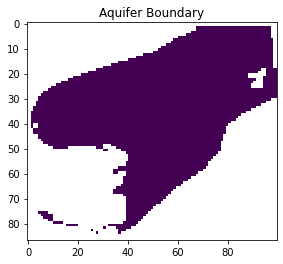

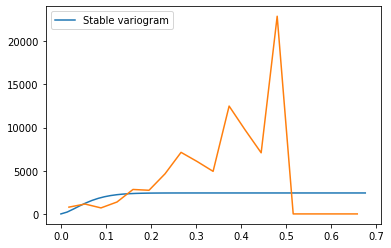

Stable(dim=2, var=2.42e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


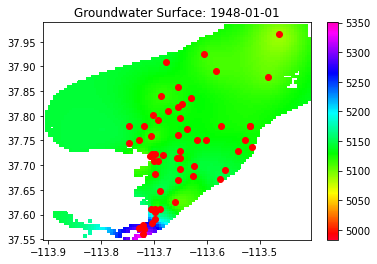

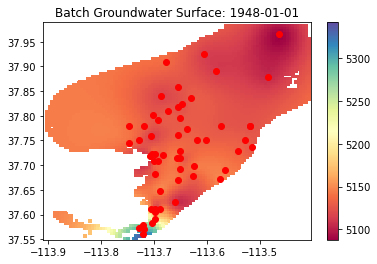

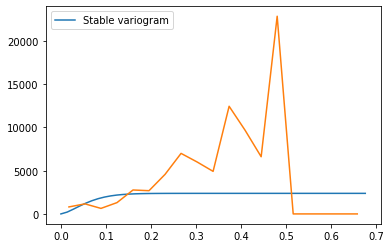

Stable(dim=2, var=2.38e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


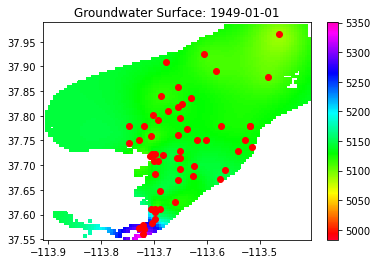

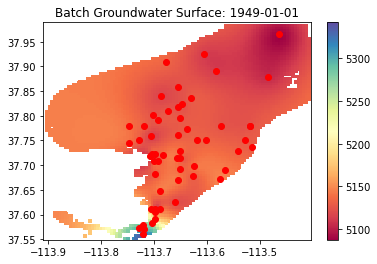

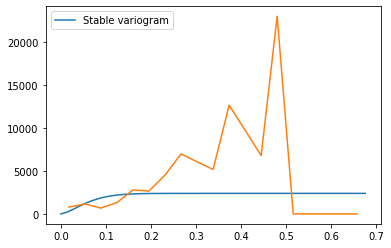

Stable(dim=2, var=2.39e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


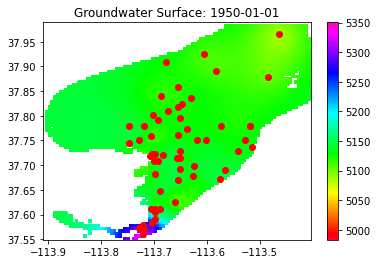

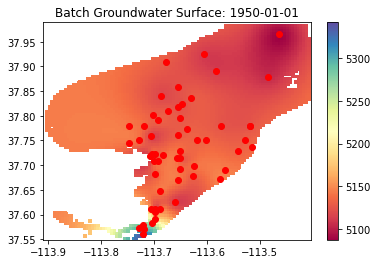

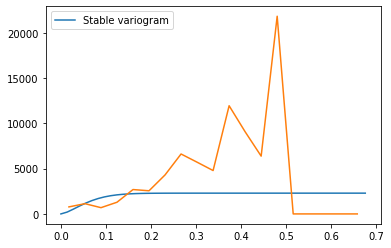

Stable(dim=2, var=2.29e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


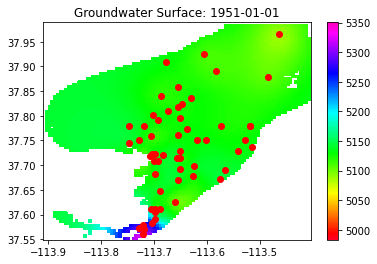

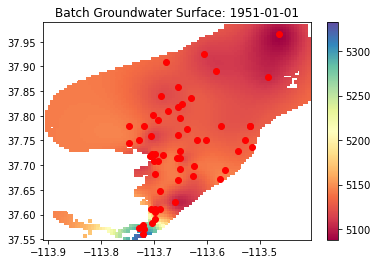

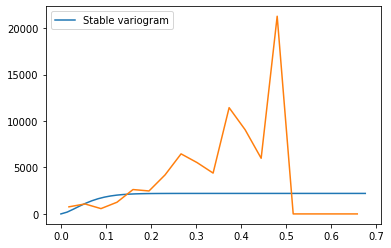

Stable(dim=2, var=2.21e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


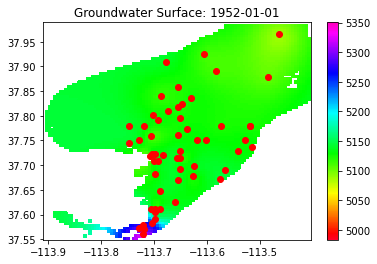

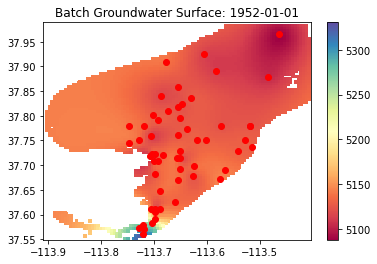

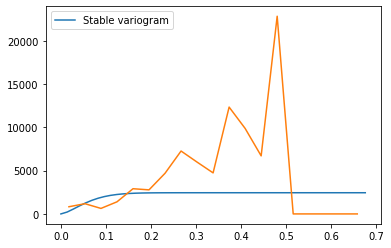

Stable(dim=2, var=2.45e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


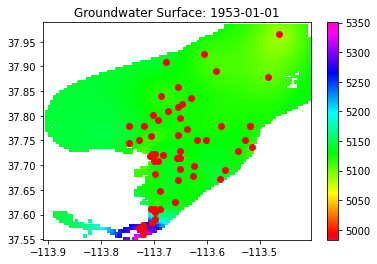

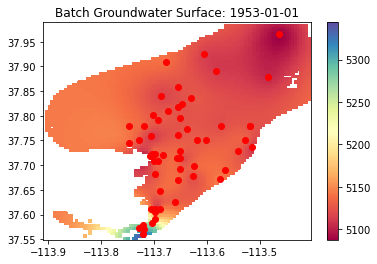

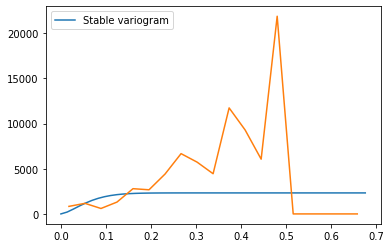

Stable(dim=2, var=2.33e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


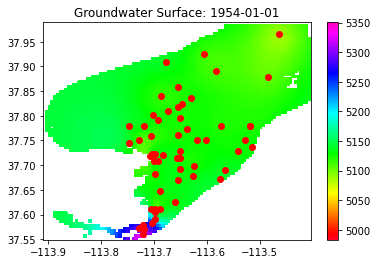

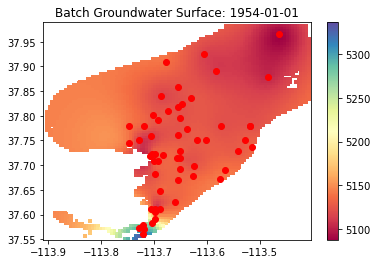

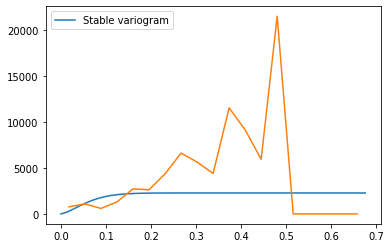

Stable(dim=2, var=2.28e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


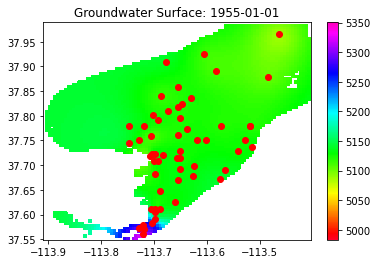

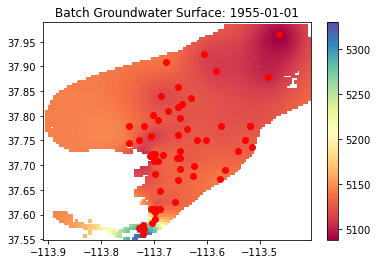

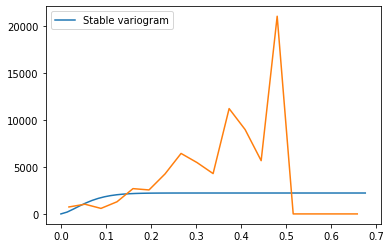

Stable(dim=2, var=2.22e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


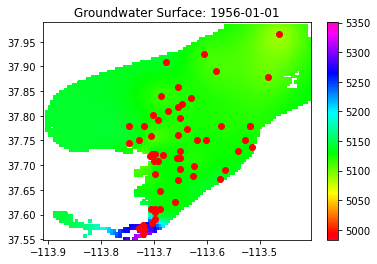

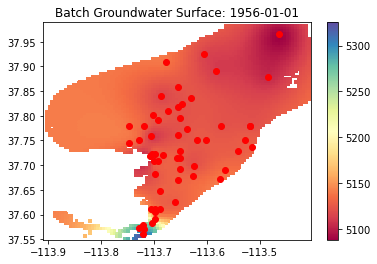

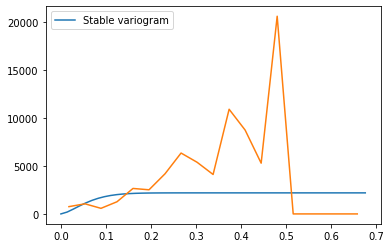

Stable(dim=2, var=2.19e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


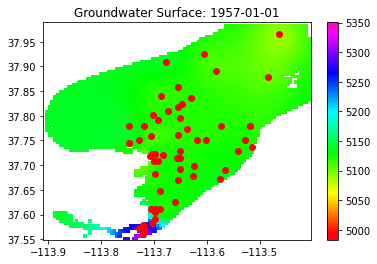

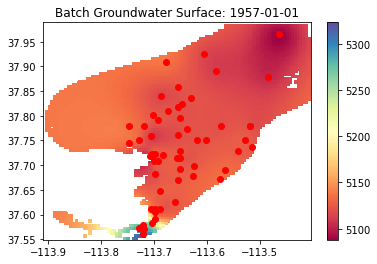

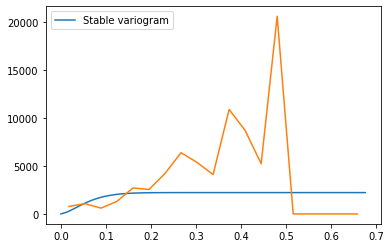

Stable(dim=2, var=2.22e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


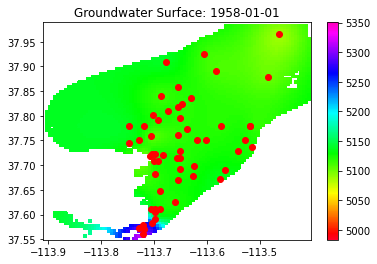

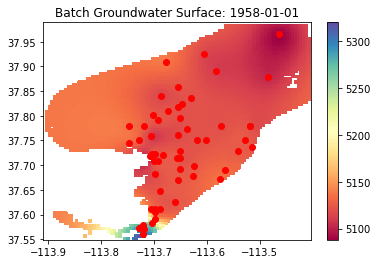

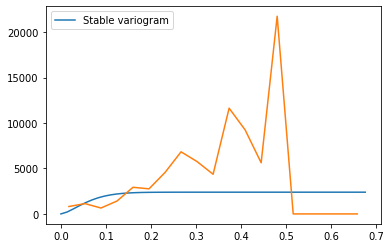

Stable(dim=2, var=2.39e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


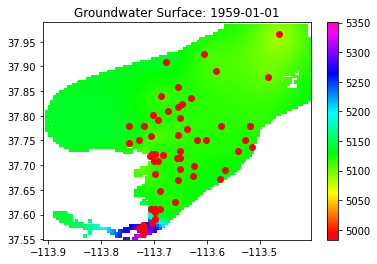

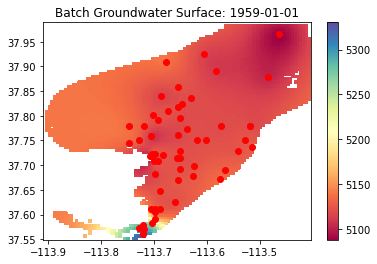

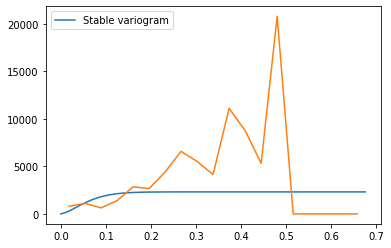

Stable(dim=2, var=2.31e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


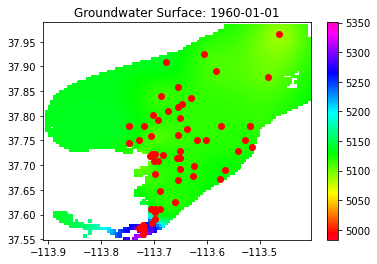

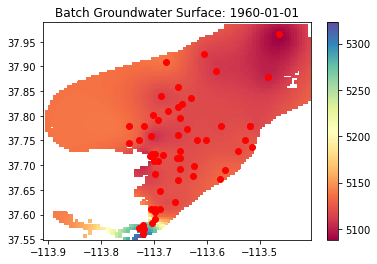

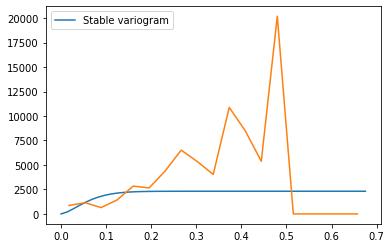

Stable(dim=2, var=2.32e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


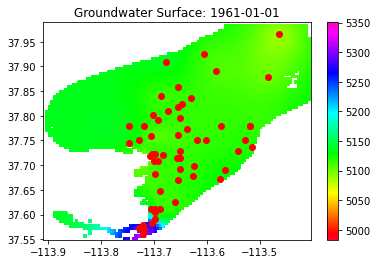

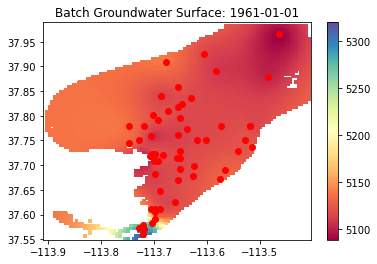

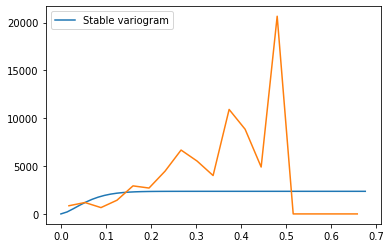

Stable(dim=2, var=2.36e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


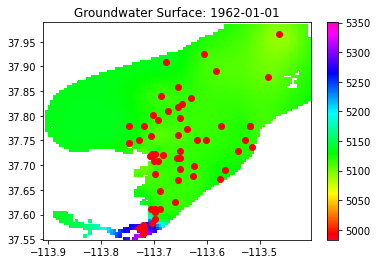

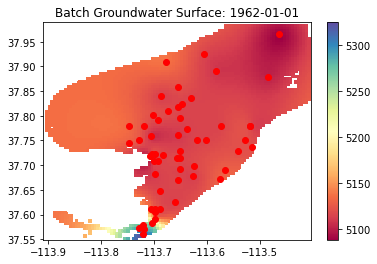

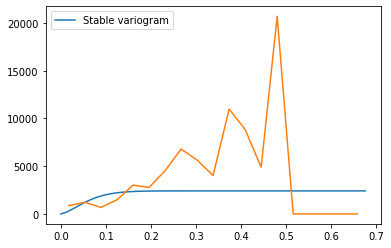

Stable(dim=2, var=2.41e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


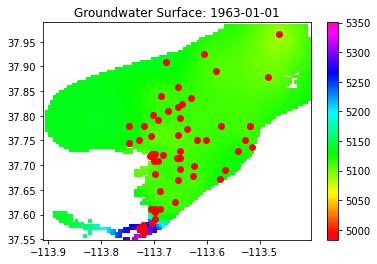

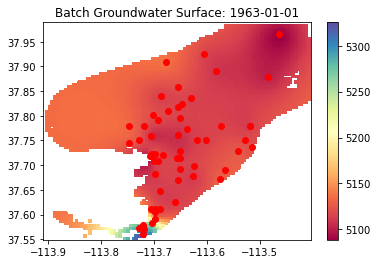

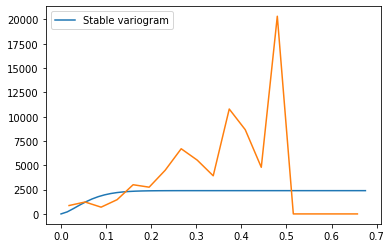

Stable(dim=2, var=2.39e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


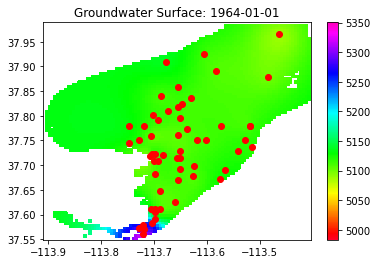

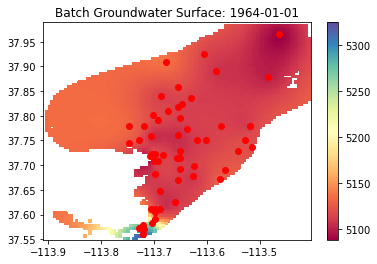

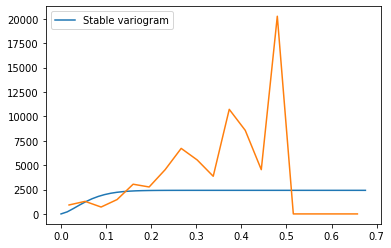

Stable(dim=2, var=2.42e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


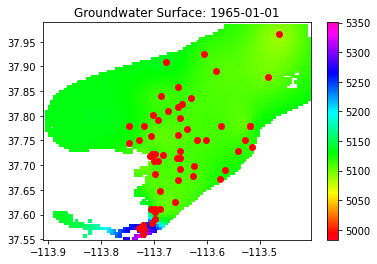

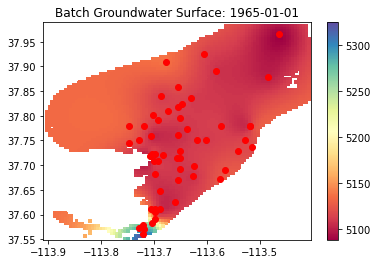

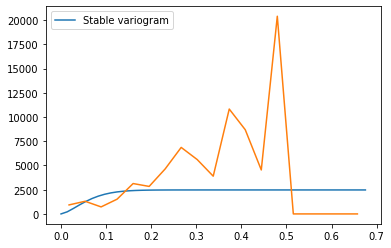

Stable(dim=2, var=2.47e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


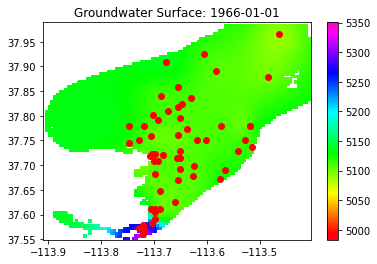

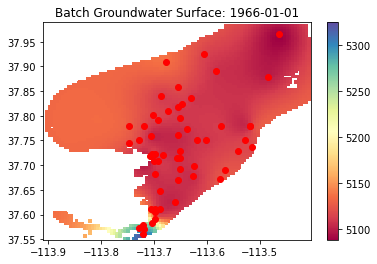

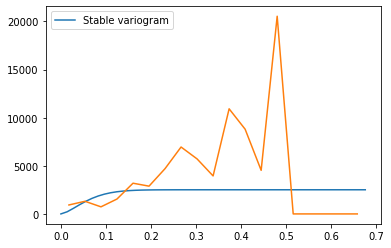

Stable(dim=2, var=2.51e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


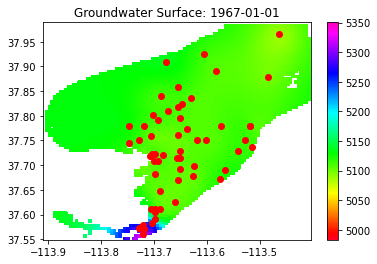

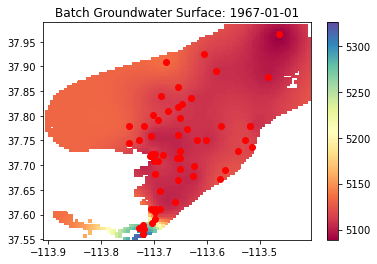

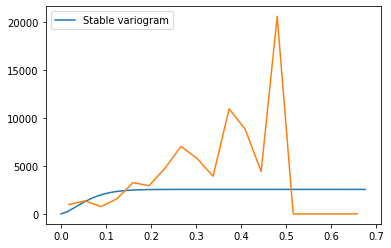

Stable(dim=2, var=2.55e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


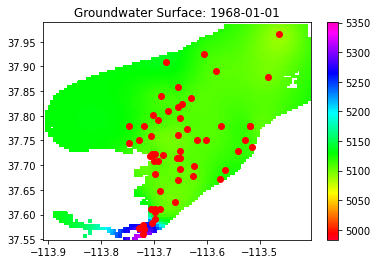

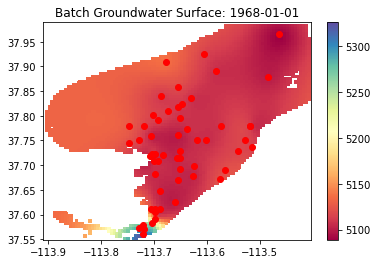

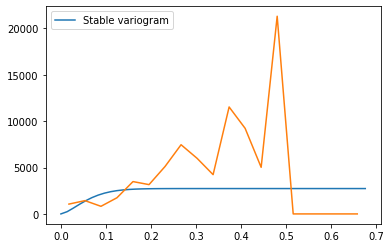

Stable(dim=2, var=2.73e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


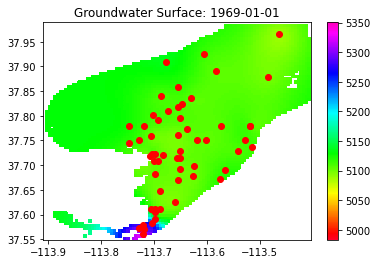

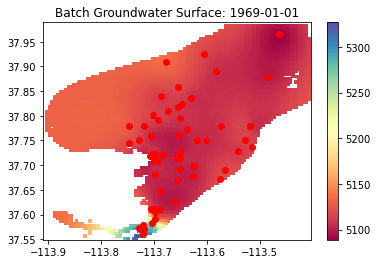

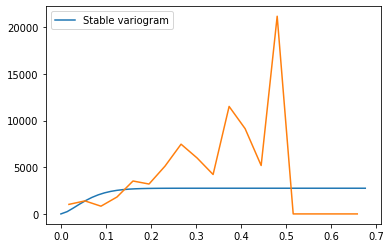

Stable(dim=2, var=2.75e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


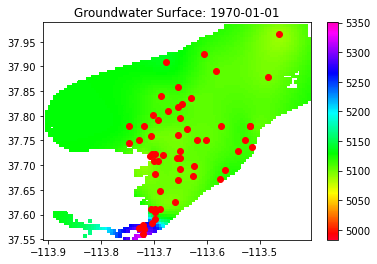

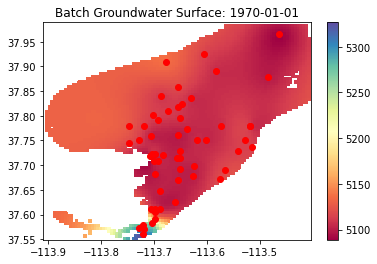

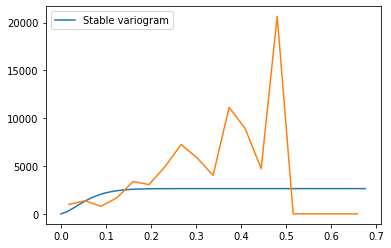

Stable(dim=2, var=2.65e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


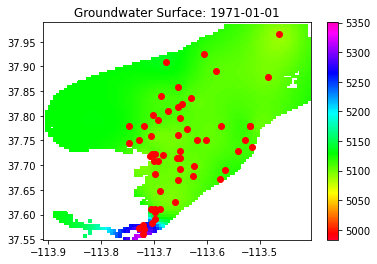

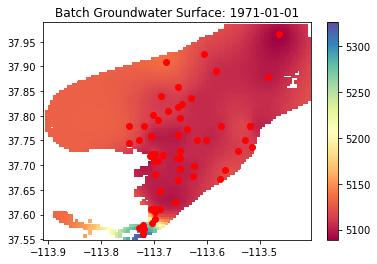

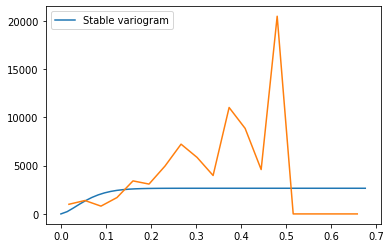

Stable(dim=2, var=2.66e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


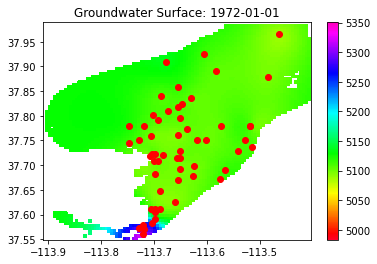

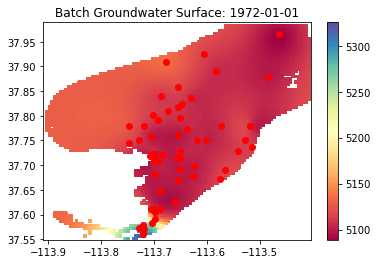

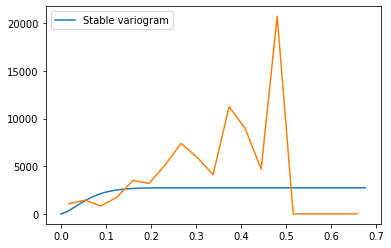

Stable(dim=2, var=2.74e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


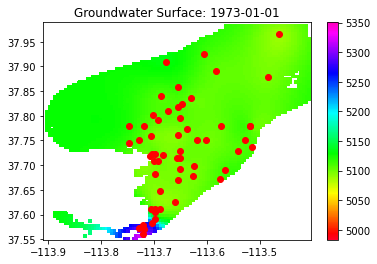

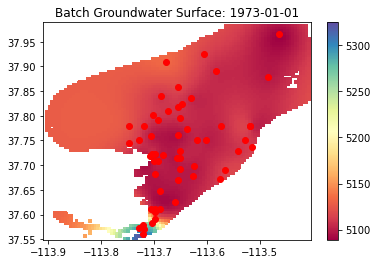

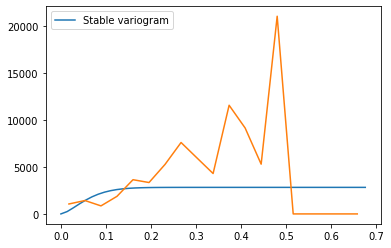

Stable(dim=2, var=2.83e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


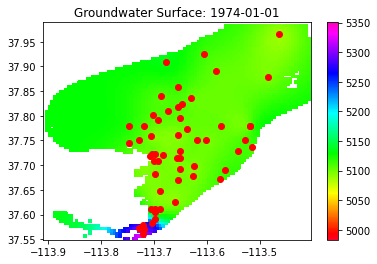

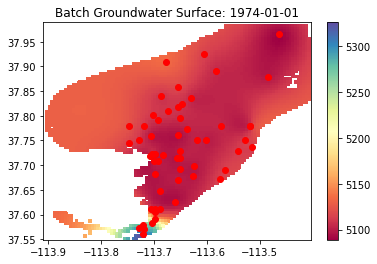

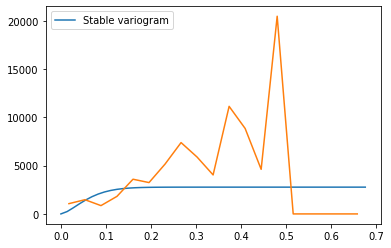

Stable(dim=2, var=2.77e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


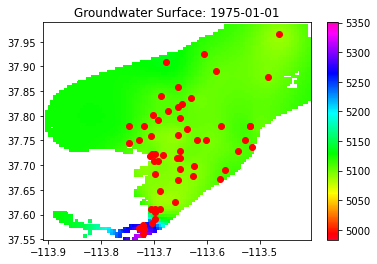

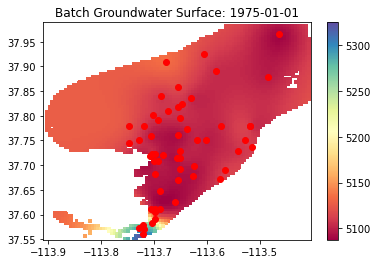

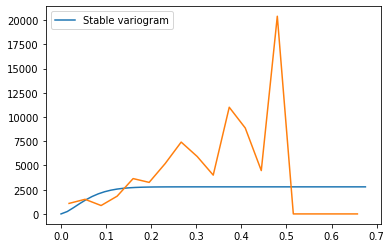

Stable(dim=2, var=2.79e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


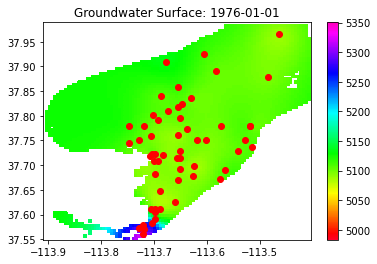

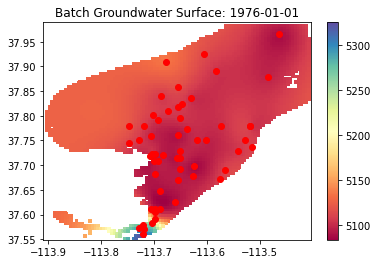

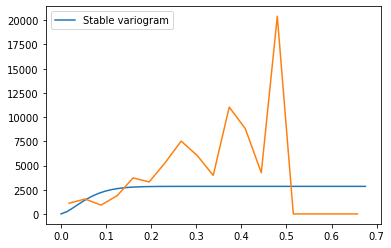

Stable(dim=2, var=2.85e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


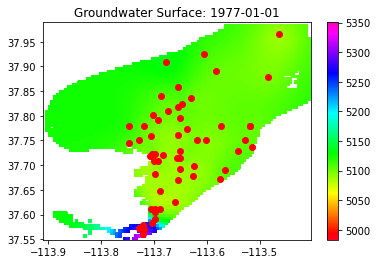

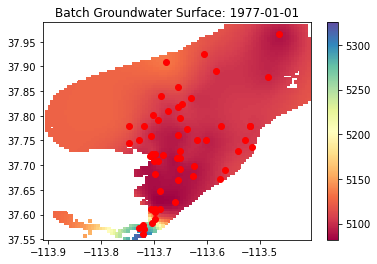

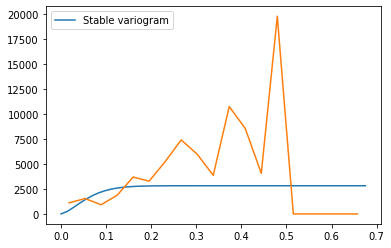

Stable(dim=2, var=2.82e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


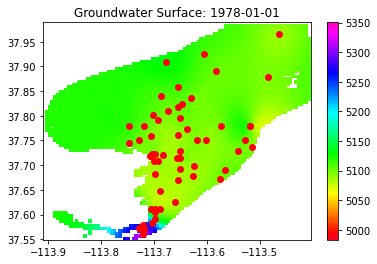

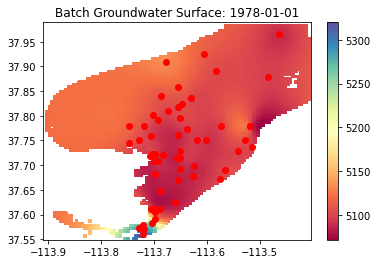

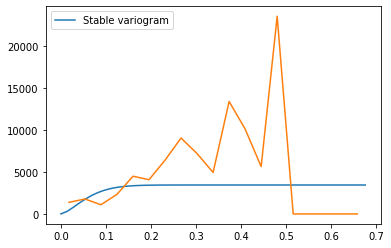

Stable(dim=2, var=3.45e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


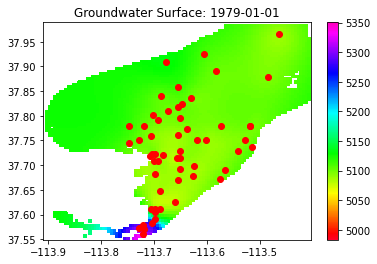

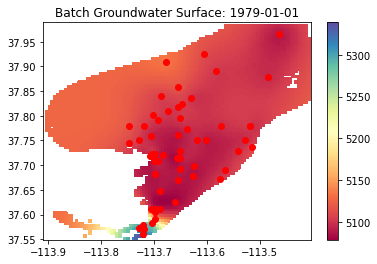

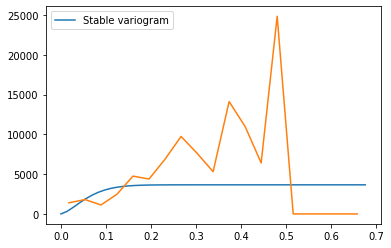

Stable(dim=2, var=3.66e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


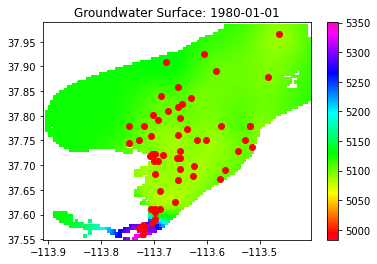

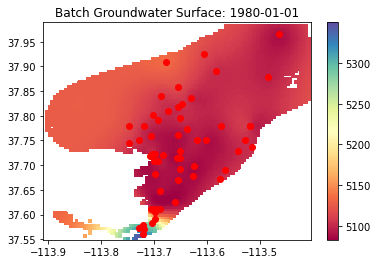

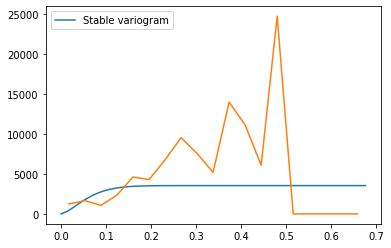

Stable(dim=2, var=3.54e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


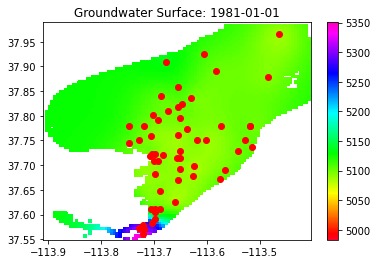

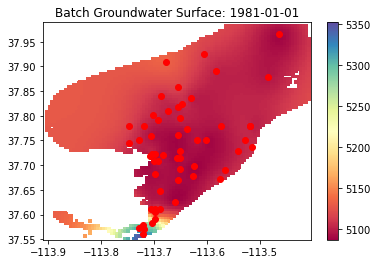

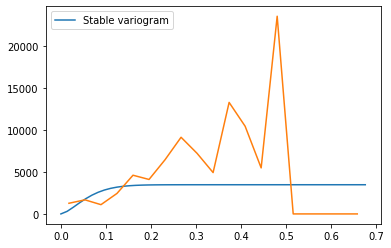

Stable(dim=2, var=3.48e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


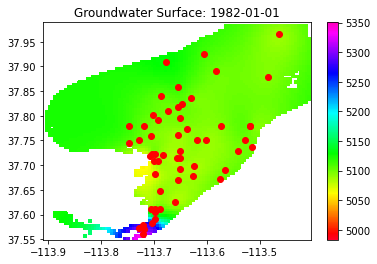

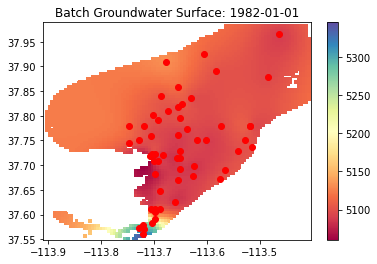

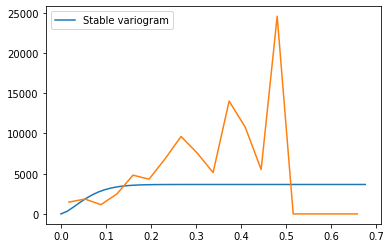

Stable(dim=2, var=3.66e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


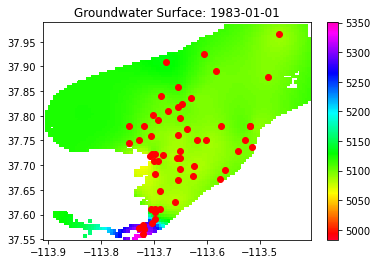

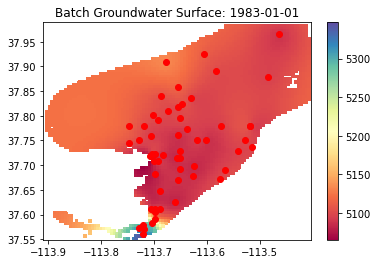

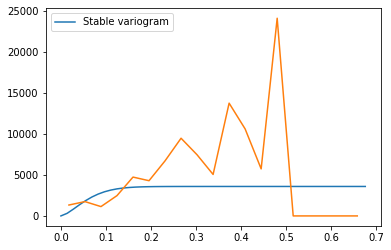

Stable(dim=2, var=3.6e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


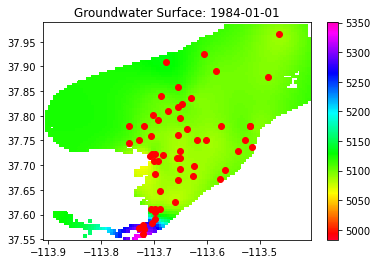

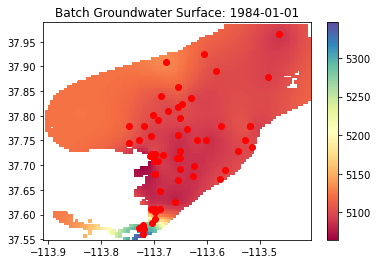

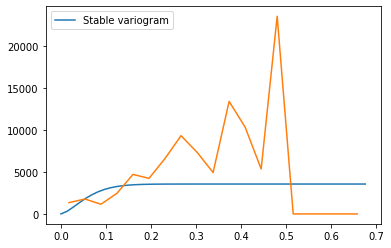

Stable(dim=2, var=3.56e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


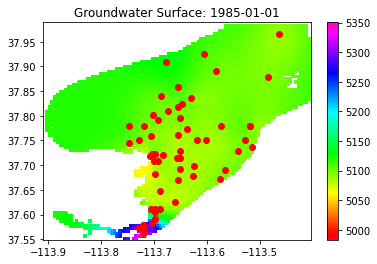

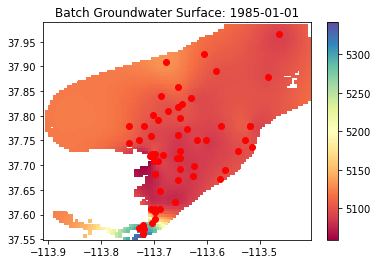

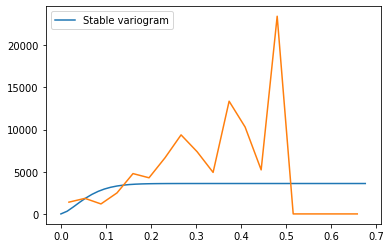

Stable(dim=2, var=3.61e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


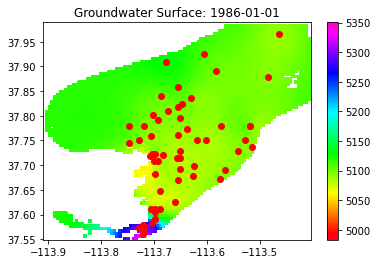

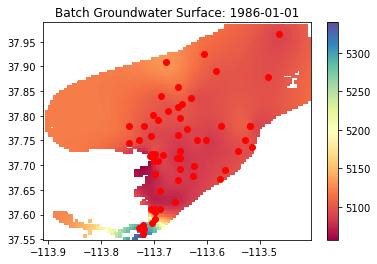

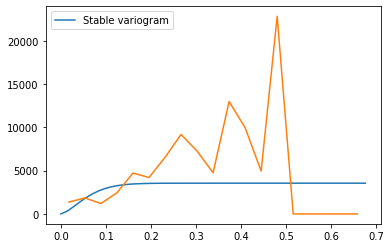

Stable(dim=2, var=3.55e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


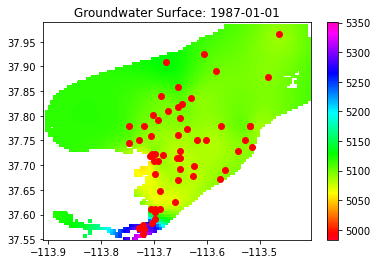

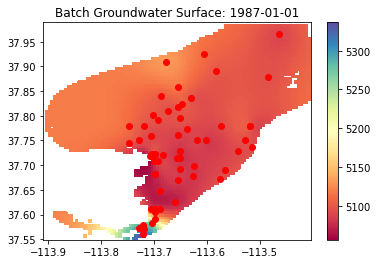

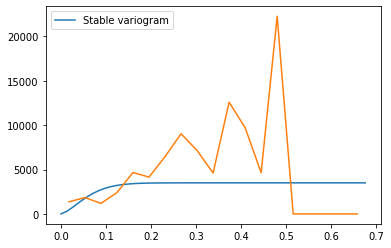

Stable(dim=2, var=3.5e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


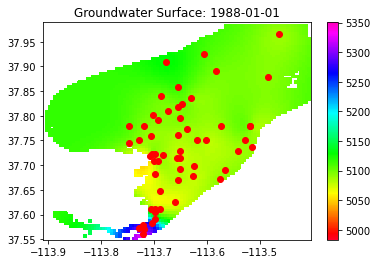

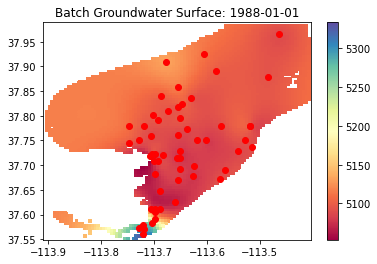

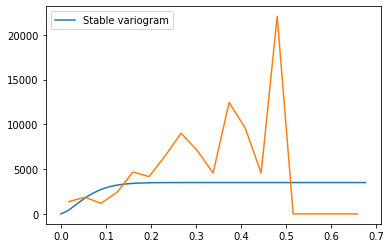

Stable(dim=2, var=3.5e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


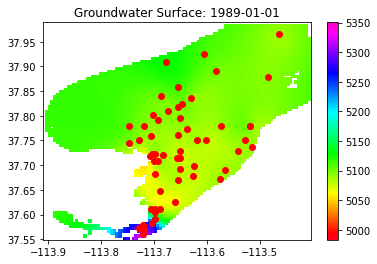

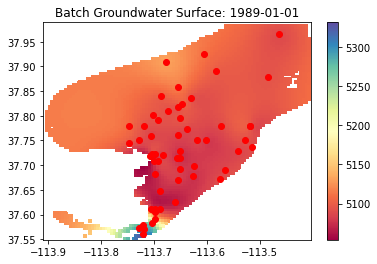

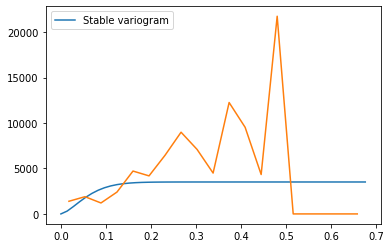

Stable(dim=2, var=3.51e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


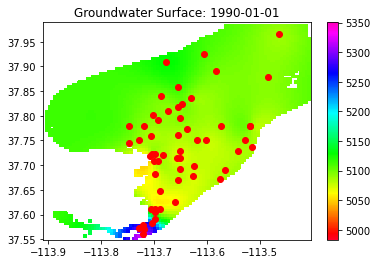

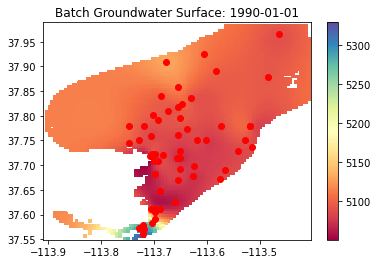

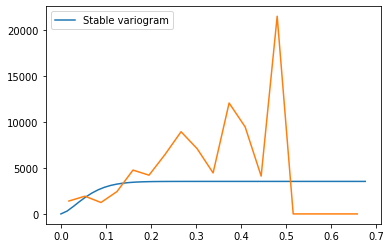

Stable(dim=2, var=3.54e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


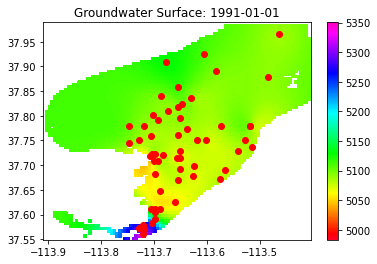

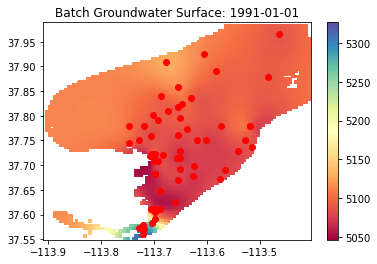

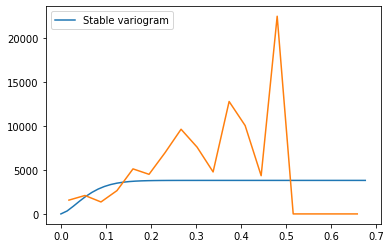

Stable(dim=2, var=3.82e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


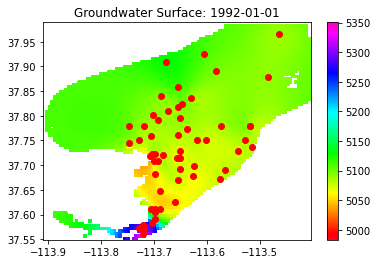

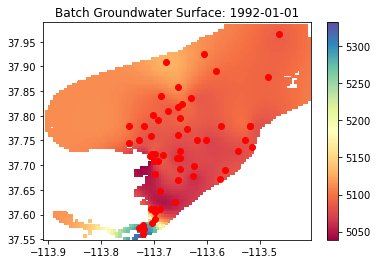

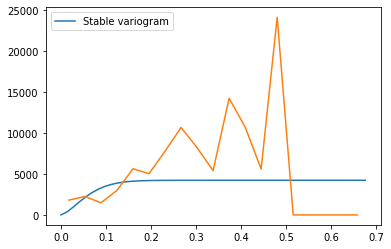

Stable(dim=2, var=4.23e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


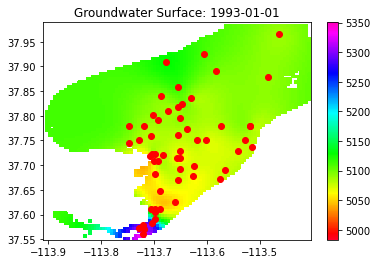

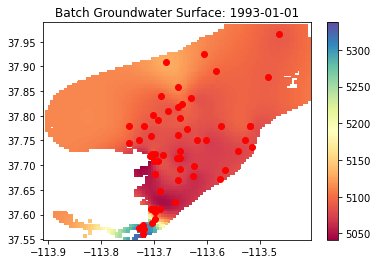

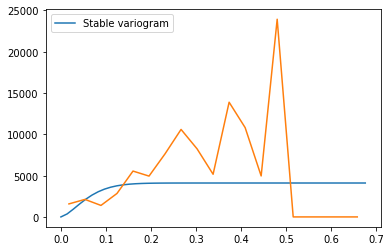

Stable(dim=2, var=4.1e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


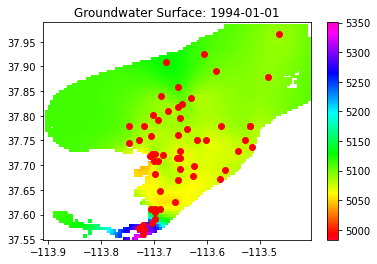

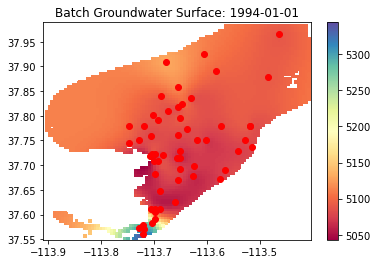

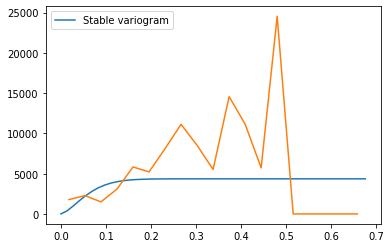

Stable(dim=2, var=4.36e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


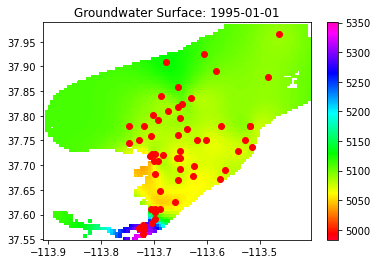

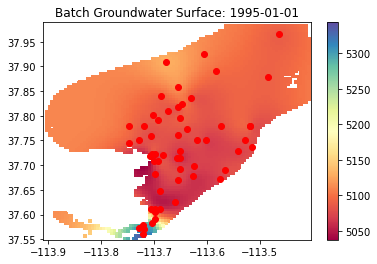

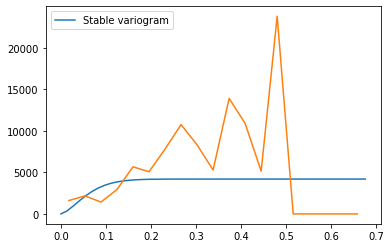

Stable(dim=2, var=4.19e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


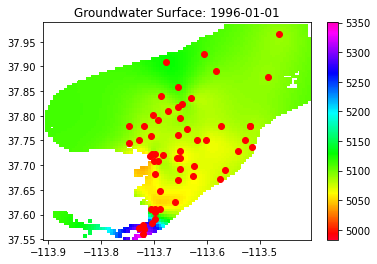

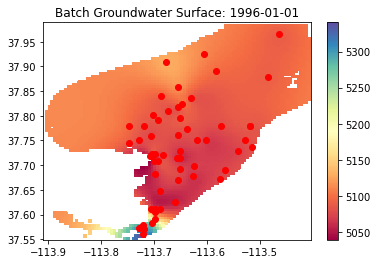

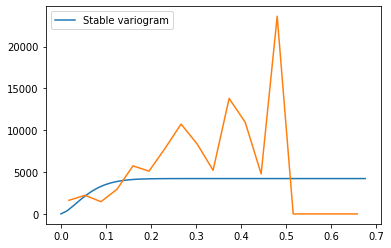

Stable(dim=2, var=4.22e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


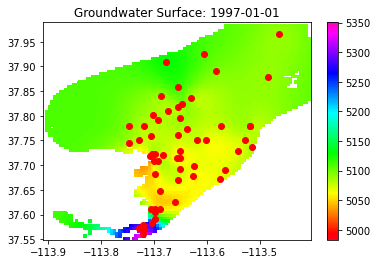

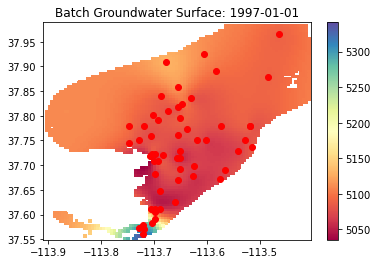

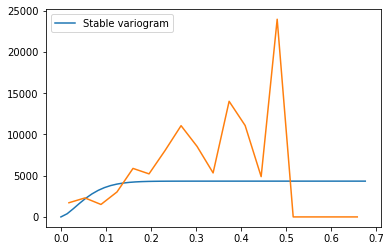

Stable(dim=2, var=4.34e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


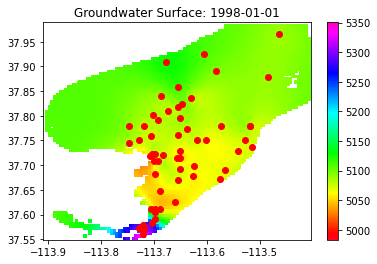

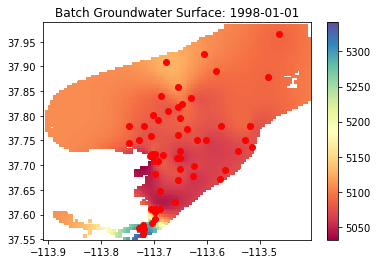

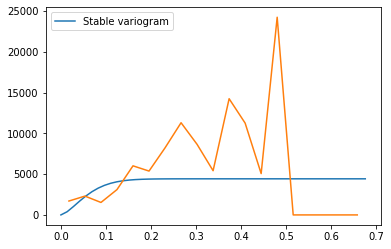

Stable(dim=2, var=4.42e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


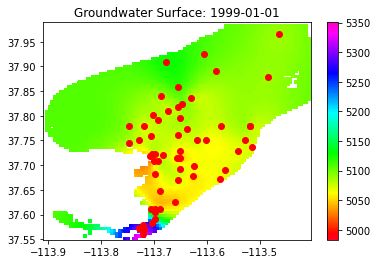

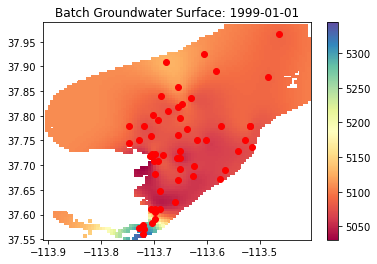

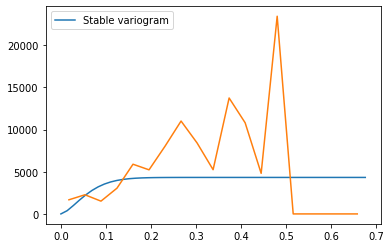

Stable(dim=2, var=4.33e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


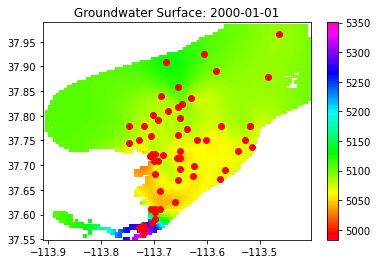

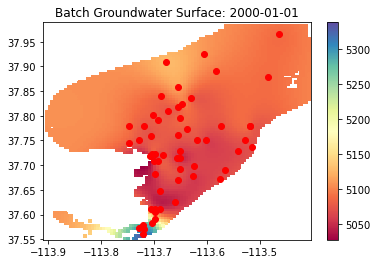

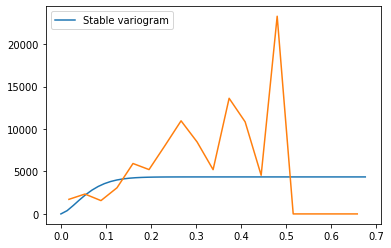

Stable(dim=2, var=4.36e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


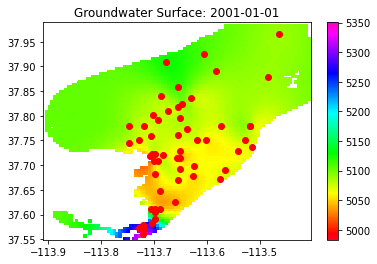

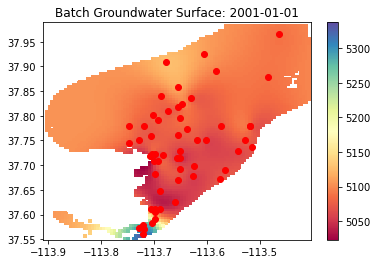

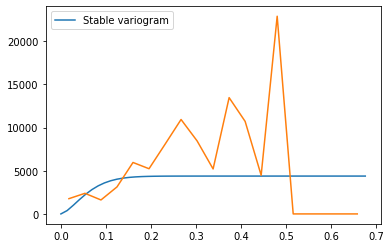

Stable(dim=2, var=4.38e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


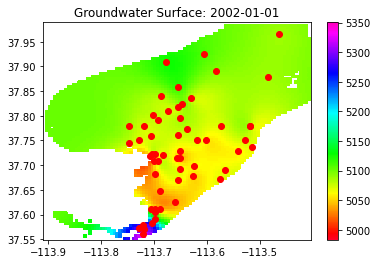

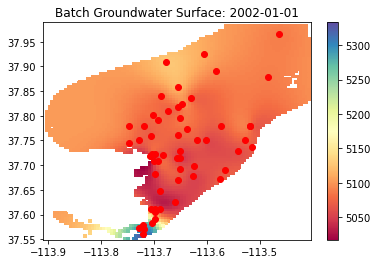

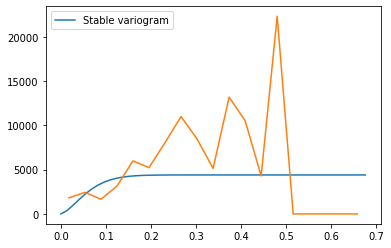

Stable(dim=2, var=4.4e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


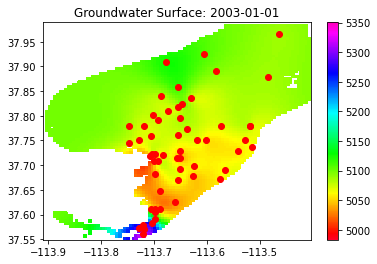

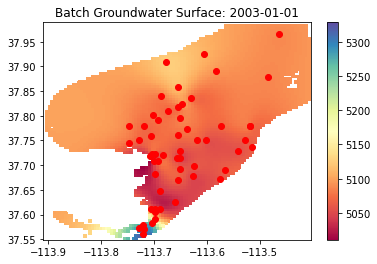

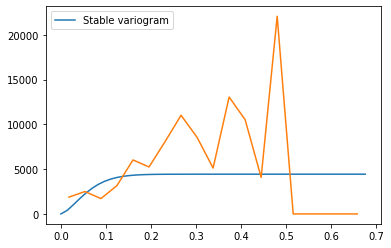

Stable(dim=2, var=4.44e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


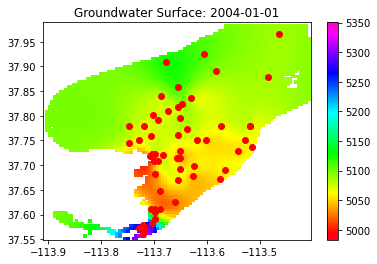

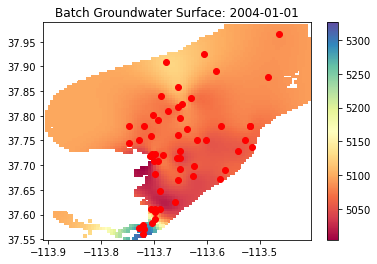

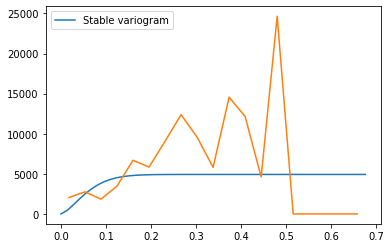

Stable(dim=2, var=4.92e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


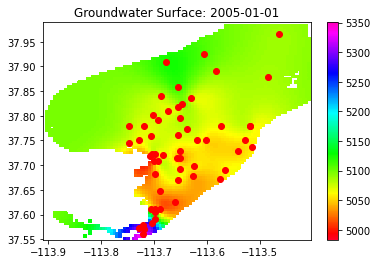

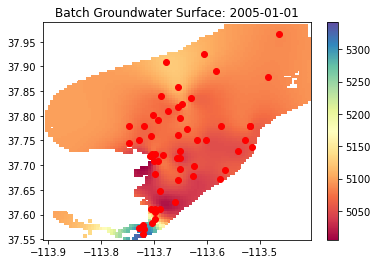

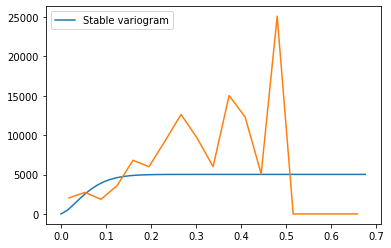

Stable(dim=2, var=5.02e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


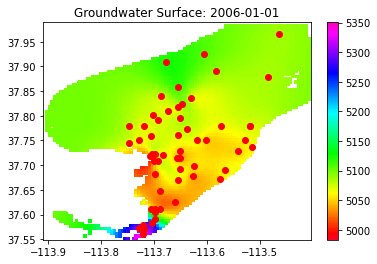

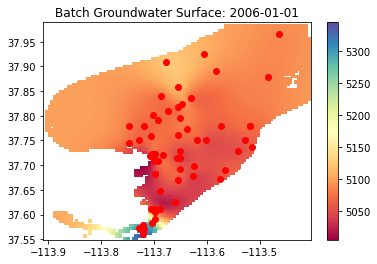

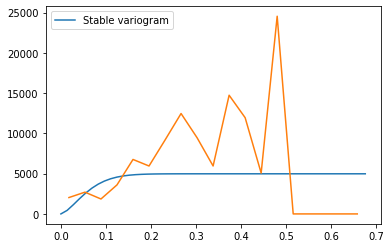

Stable(dim=2, var=4.98e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


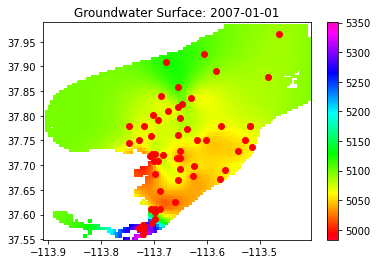

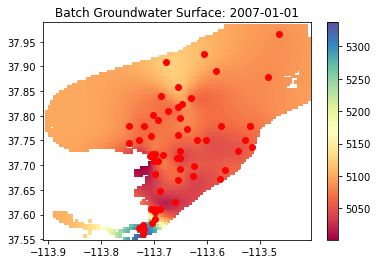

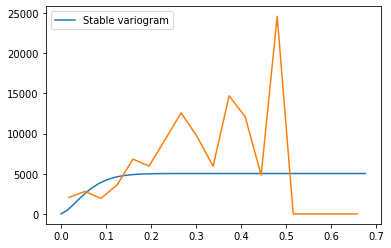

Stable(dim=2, var=5.03e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


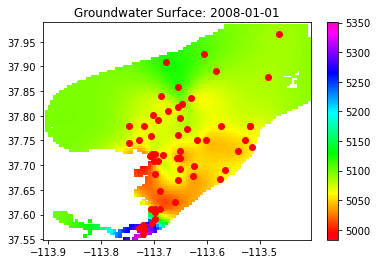

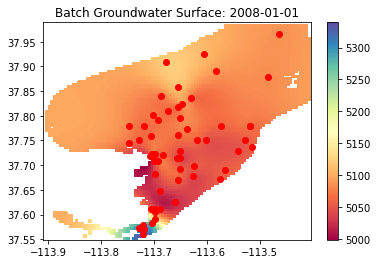

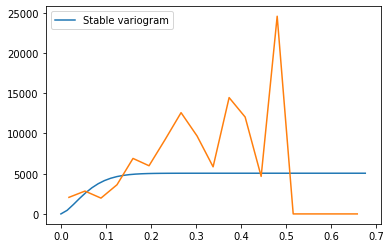

Stable(dim=2, var=5.05e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


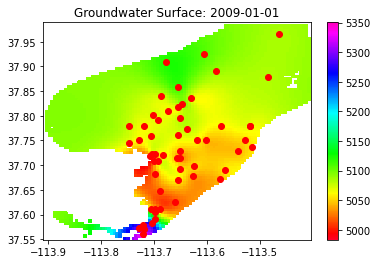

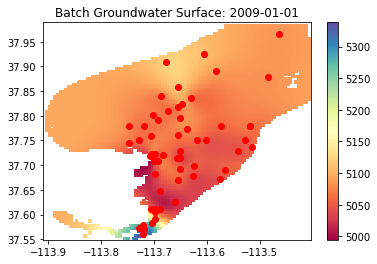

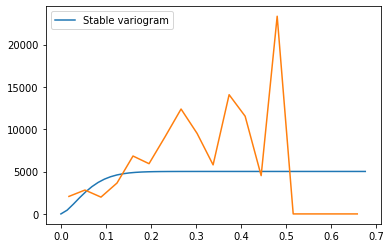

Stable(dim=2, var=5.02e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


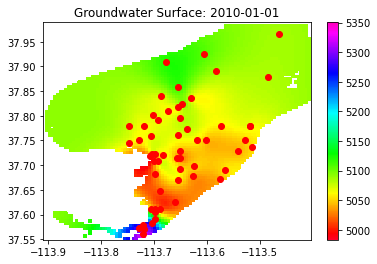

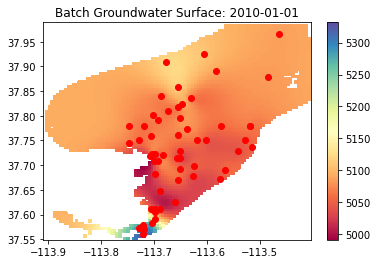

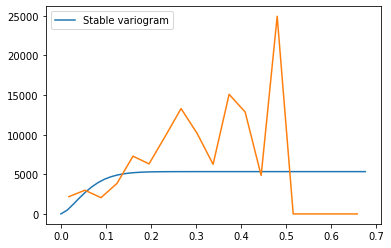

Stable(dim=2, var=5.34e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


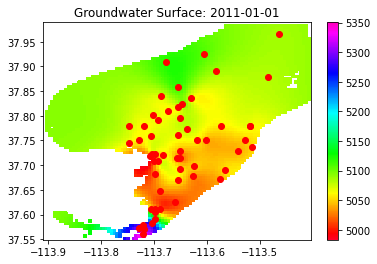

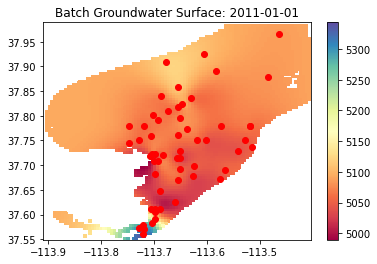

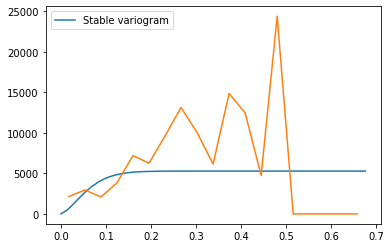

Stable(dim=2, var=5.29e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


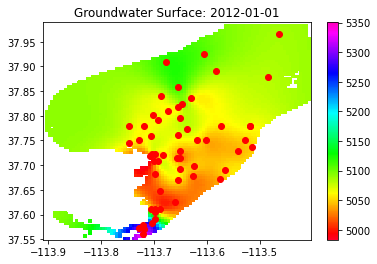

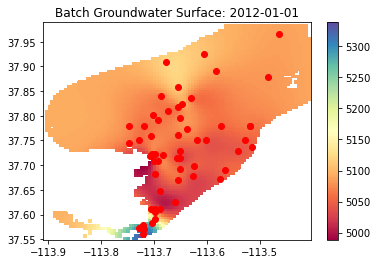

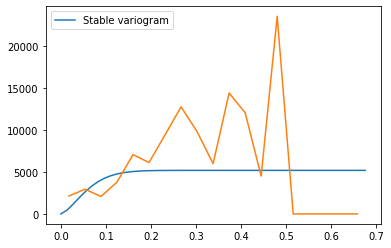

Stable(dim=2, var=5.18e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


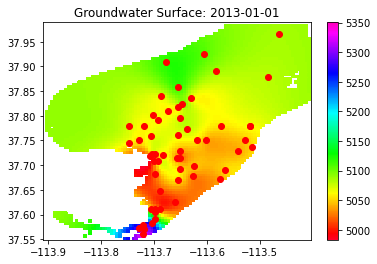

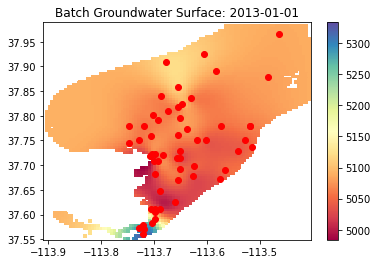

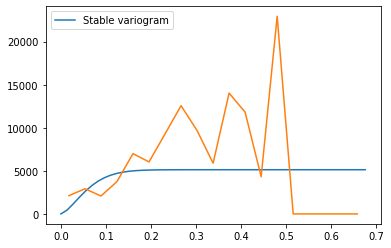

Stable(dim=2, var=5.13e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


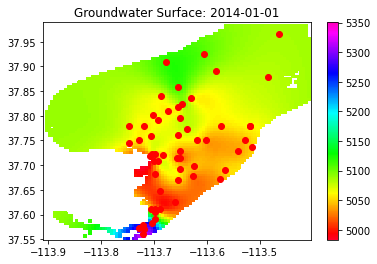

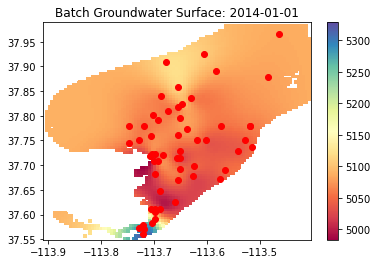

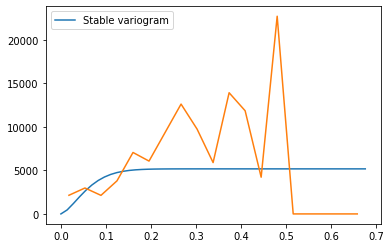

Stable(dim=2, var=5.18e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


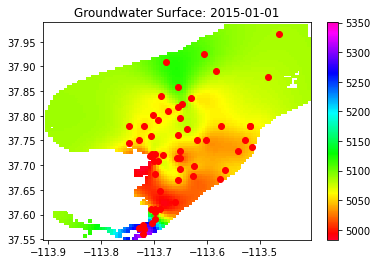

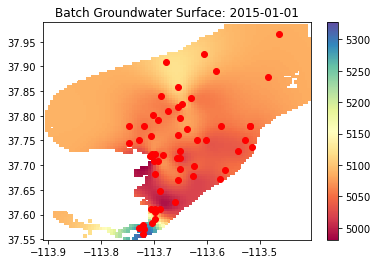

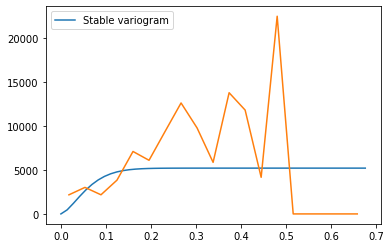

Stable(dim=2, var=5.2e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


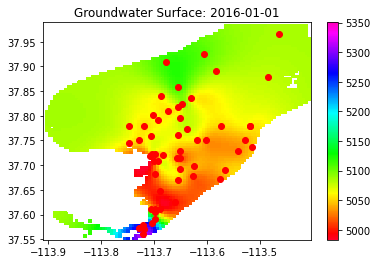

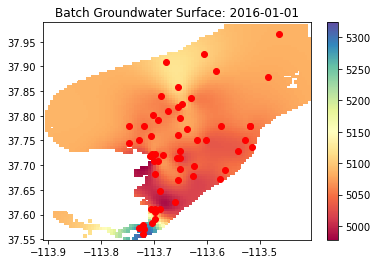

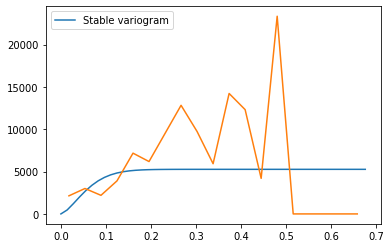

Stable(dim=2, var=5.27e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


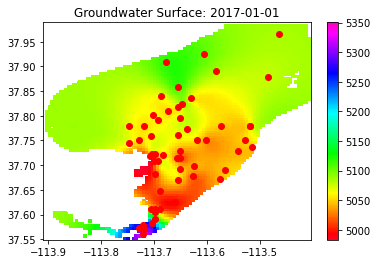

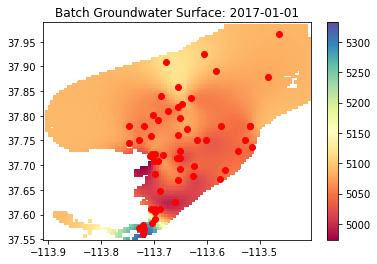

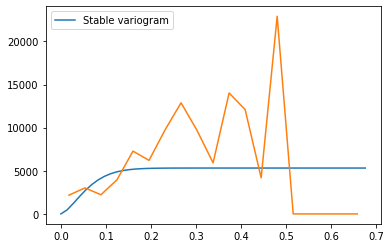

Stable(dim=2, var=5.32e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


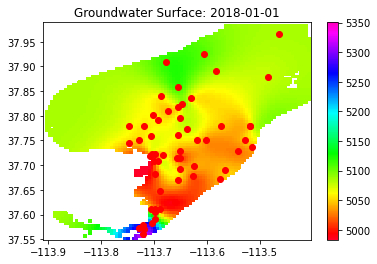

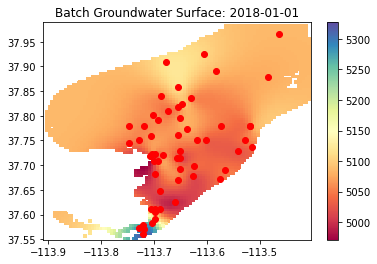

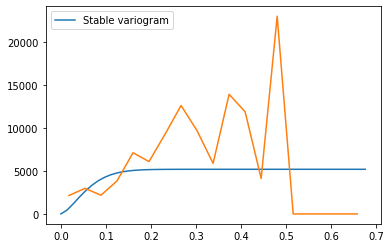

Stable(dim=2, var=5.18e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


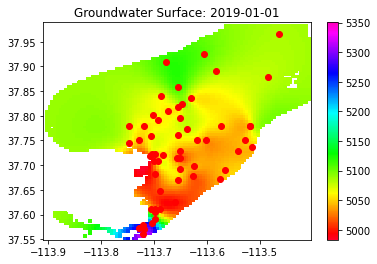

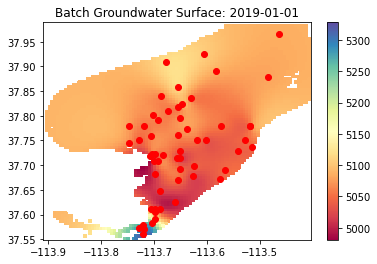

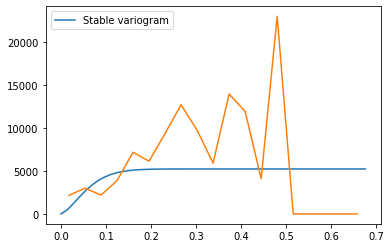

Stable(dim=2, var=5.23e+03, len_scale=0.0675, nugget=0.0, alpha=1.5)


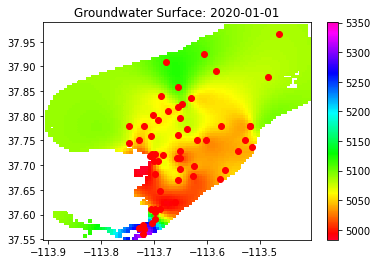

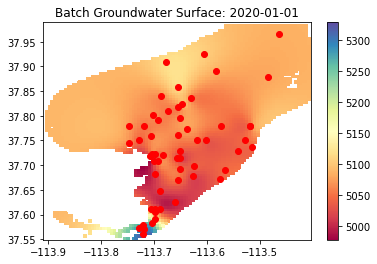

NetCDF Created.


In [ ]:
#@markdown ### **Select parameters (or leave defaults) and run this cell to perform spatial interpolation using kriging**

data_root = '/content/Datasets/' # Data Locations
figures_root = '/content/Figures Spatial' # Location where figures are saved
netcdf_filename = 'well_data.nc' # Naming netcdf output
if os.path.exists(data_root+'well_data.nc'): 
  raise SystemExit("There is a pre-existing well_data.nc raster file. Delete, then re-run.")
  
#@markdown #### Specify the time interval at which a new raster will be interpolated, in months:
Time_Step = 12 #@param {type:"integer"}
skip_month = Time_Step
Load_Smooth_Model_Output = True #@param {type:"boolean"}
#@markdown ---

#@markdown #### Specify the influence:
#@markdown *The influence is a parameter that adjusts the distance within the aquifer from a particular point that affects that point during kriging.*
influence = 0.1 #@param {type:"number"}

#@markdown ---

#@markdown #### Specify ONE of the following, or leave all as 'None'. If all parameters are left as 'None', the script will resort to using square grids of size 0.1 degrees:

#@markdown ##### *Specify resolution of the raster based on number of cells along the x-axis* 
x_cells =  100#@param {type:"raw"}
#@markdown ##### *Specify resolution of the raster based on number of cells along the y-axis*
y_cells =  None#@param {type:"raw"}
#@markdown ##### *Specify resolution without reference to number of cells in shape*
res = None #@param {type:"raw"}
for param in [x_cells, y_cells, res]:
  if param is not None and param <= 0:
    print("Error: Make sure your parameter is a number greater than 0 and all non-specified values are 'None'")

# Initiate class creating data and figure folder
inter = utils_06_spatial.krigging_interpolation(data_root, figures_root)

# Load complete pickle file
well_data_dict = inter.read_pickle('Well_Data_Imputed', data_root)
if Load_Smooth_Model_Output == False:
  well_data = well_data_dict['Data'].dropna() # Unpack Time series Drop NAs
else:
  well_data = well_data_dict['Data_Smooth'].dropna() # Unpack Time series Drop NAs

x_coordinates = well_data_dict['Location']['Longitude'] # Unpack Longitude of wells
y_coordinates = well_data_dict['Location']['Latitude'] # Unpack Latitude of wells

# Load respective aquifer shape file
polygon = inter.Shape_Boundary('/content/Aquifer_Shapes/' + aqFile[:-4] + '.shp')

# Line creates grid and mask based on the bounding box of the aquifer
# Grid is created based on resolution determined by x_cells, y_cells or res
# where priority is x_cells > y_cells > res. 
grid_long, grid_lat = inter.create_grid_polygon(polygon, x_cells = x_cells, y_cells = y_cells, res = res)

# Extract every nth month of data
data_subset = inter.extract_dataframe_data(well_data, skip_month)

# This sets up a netcdf file to store each raster in.
file_nc, raster_data = inter.netcdf_setup(grid_long, grid_lat, data_subset.index, netcdf_filename)

# Loop through each date, create variogram for time step create krig map.
# Inserts the grid at the timestep within the netCDF.
for i, date in enumerate(data_subset.index):
    # Filter values associated with step
    values = data_subset.loc[data_subset.index[i]].values

    # fit the model variogram to the experimental variogram
    var_fitted = inter.fit_model_var(x_coordinates, y_coordinates, values, influence = influence)  # fit variogram
                                                                            # influence, try 1/8, 1/4, 1/2, (how far from the point it is influenced by)
    
    # when kriging, you need a variogram. The subroutine has a function to plot
    # the variogram and the experimental. Variable 'influence' is the percentage
    # of the total aquifer length where wells are correlated. set 0.125 - 0.875

    krig_map = inter.krig_field(var_fitted, x_coordinates, y_coordinates, values, grid_long, grid_lat, date) # krig data

    # krig_map.field provides the 2D array of values
    # this function does all the spatial interpolation using the variogram from above.
    # Removes all data outside of boundaries of shapefile.
    # write data to netcdf file
    raster_data[i,:,:] = krig_map.field  # add kriged field to netcdf file at time_step

file_nc.close()

print('NetCDF Created.')

In [ ]:
#@markdown ### **(Optional) Run this cell to download the interpolated well data NetCDF file to local machine**
files.download('/content/Datasets/well_data.nc')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---

<a name="storage"></a>
## **Step 5: Calculate Storage Depletion Curve**

[Load packages and utility files, if necessary](#loadUtils)

In [ ]:
#@markdown ### **Run this cell to upload imputed data file (if starting from a new session)**
Upload_File = False #@param {type:"boolean"}

if Upload_File == True:
  if not os.path.isdir('Datasets'): 
    !mkdir Datasets
  print("Upload Well_Data.nc NetCDF file from step 4\n")
  uploaded = files.upload()
  raster_file = list(uploaded.keys())[0]
  os.rename('/content/'+raster_file,'/content/Datasets/'+raster_file)
else: 
  raster_file ='well_data.nc'
  print("If your file is not uploaded in the current session, check the Upload_File box on the right side of the cell and re-run the cell. Otherwise, continue to next cell.")

If your file is not uploaded in the current session, check the Upload_File box on the right side of the cell and re-run the cell. Otherwise, continue to next cell.


The area of the aquifer is 0.28 million acres.



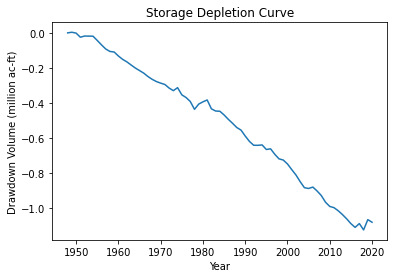

In [ ]:
#@markdown ### **Run this cell to calculate storage depletion curve**
#@markdown *Specify system of measurement for imputed data*
units = "English" #@param ["English", "Metric"]
if units == "Metric": 
  unit_coeff, area_coeff, vol_coeff, area_lab, vol_lab = 0.3048, 1, 1000, 'km^2', 'km^3'
else: 
  unit_coeff, area_coeff, vol_coeff, area_lab, vol_lab = 1, 43560, 1, 'million acres', 'million ac-ft'
#@markdown *Specify the storage coefficient of the aquifer*
storage_coefficient = 0.07 #@param {type:"number"}

imputed_raster = nc.Dataset('/content/Datasets/'+raster_file)

# Calculate the area of the aquifer
yRes = abs(round(imputed_raster['lat'][0] - imputed_raster['lat'][1], 7)) # this assumes all cells will be the same size in one dimension (all cells will have same x-component)
xRes = abs(round(imputed_raster['lon'][0] - imputed_raster['lon'][1], 7))
area = 0
# Loop through each y row
for y in range(imputed_raster.dimensions['lat'].size):
  # Define the upper and lower bounds of the row
  mylatmax = math.radians(imputed_raster['lat'][y] + (yRes/2))
  mylatmin = math.radians(imputed_raster['lat'][y] - (yRes/2))

  # Count how many cells in each row are in aquifer (i.e. and, therefore, not nan)
  xCount = 0
  for x in range(imputed_raster.dimensions['lon'].size):
    if not math.isnan(imputed_raster['tsvalue'][0, y, x]):
      xCount += 1
  
  # Area calculated based on the equation found here: https://www.pmel.noaa.gov/maillists/tmap/ferret_users/fu_2004/msg00023.html
  #     (pi/180) * R^2 * |lon1-lon2| * |sin(lat1)-sin(lat2)| 
  #     radius is 3958.8 mi
  area += (3958.8 * 5280 * unit_coeff)**2 * math.radians(xRes * xCount) * abs((math.sin(mylatmin) - math.sin(mylatmax)))
print("The area of the aquifer is %.2f %s.\n" %(area / 10**6 / area_coeff, area_lab))

# Calculate total drawdown volume at each time step
drawdown_grid = np.zeros((imputed_raster.dimensions['time'].size, imputed_raster.dimensions['lat'].size, imputed_raster.dimensions['lon'].size))
drawdown_volume = np.zeros(imputed_raster.dimensions['time'].size)
for t in range(imputed_raster.dimensions['time'].size):
  drawdown_grid[t, :, :] = imputed_raster['tsvalue'][t, :, :] - imputed_raster['tsvalue'][0, :, :] # Calculate drawdown at time t by subtracting original WTE at time 0
  drawdown_volume[t] = np.nanmean(drawdown_grid[t, :, :] * storage_coefficient * area ) # Average drawdown across entire aquifer * storage_coefficient * area of aquifer

# Plot storage depletion curve
x_data = pd.Series(imputed_raster['time'][:], dtype=int).apply(lambda x: datetime.datetime.fromordinal(x)) # Convert from days since 0001-01-01 00:00:00
y_data = drawdown_volume / 10**6 / area_coeff / vol_coeff
plt.plot(x_data, y_data)
plt.xlabel("Year")
plt.ylabel("Drawdown Volume (%s)" %(vol_lab))
plt.title("Storage Depletion Curve")
plt.show()

### <font color='dimgray'>Compare to GRACE</font>

In [ ]:
#@markdown ### **Run this cell to upload a GRACE csv file**

uploaded = files.upload()
wellsFile = ''.join(uploaded)
GRACE = pd.read_csv(wellsFile)

In [ ]:
#@markdown ### **Specify paramters and run the cell to create comparison plot of GRACE and imputed data**

#@markdown *Specify what year to start plotting the imputed data (will round to closest date) or start at same date as GRACE*
start_date = "2001-12-01" #@param {type:"date"}
match_GRACE = False #@param {type:"boolean"}
#@markdown *Specify any identifying parameters you would like to include in the title of the plot*
plot_title = "150 Obs, short PDSI, 0.07 storage coeff" #@param {type:"string"}

# Set up time series data from imputed drawdown volume and GRACE
x2 = GRACE['Date'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000))  # milliseconds since epoch converted to date
y2 = GRACE['Groundwater Storage (Calculated)'][0:] - GRACE['Groundwater Storage (Calculated)'][0]  # water level equivalent in cm
# Select the appropriate subset of the imputed data
if match_GRACE: date = x2[0]
else: date = datetime.datetime.strptime(start_date, '%Y-%m-%d')
closest_date = min(x_data, key=lambda x: abs(x - date))
start_index = x_data[x_data == closest_date].index[0]
x1 = x_data[start_index:]
y1 = ( drawdown_volume[start_index:] - drawdown_volume[start_index] ) / area * (0.3048/unit_coeff) * 100 # water level equivalent in cm

# Create plot
plt.plot(x1,y1, label="Imputed Data")
plt.plot(x2,y2, label="GRACE")
plt.xlabel("Year")
plt.ylabel("Liquid Water Equivalent Thickness (cm)")
plt.legend()
plt.title('GRACE COMPARISON\n'+plot_title)
plt.savefig('GRACE_comp_'+str(storage_coefficient)+'.png')
plt.show()

## **Retrieve Files**
1. Check the 'Files' panel on the left for your new files. 
2. Go to the 'Datasets' folder to find the well_data.nc, Well_Data_Imputed.pickle, and 06_Error_Metrics.h5 files. 
3. Click the three dots next to each file to download it.
*(Hit the refresh button if you do not see the new file initially)*

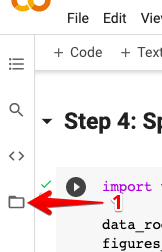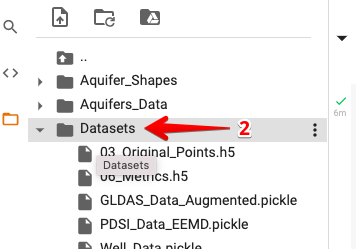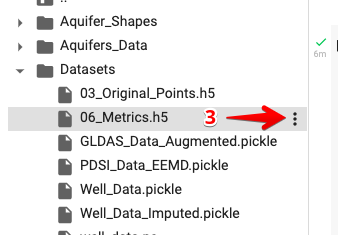

---

---

---

## **Appendix**

In [ ]:
#@markdown <a name="download"></a>
#@markdown ### **Allow Colab to Download Multiple Files**
#@markdown In order to download multiple files at once in Colab, you must allow Colab to do so. 
#@markdown 1. You can run this cell, which will download some small sample data files. 
#@markdown 2. A popup from your browser will appear, asking for permission to download multiple files. You only have to do this once per session. 
#@markdown 3. Afterwards, you can delete the downloaded files.

sample_data = ['/content/sample_data/california_housing_test.csv', 
               '/content/sample_data/california_housing_train.csv', 
               '/content/sample_data/anscombe.json']
for file in sample_data:
  files.download(file)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@markdown ### **Trim off the last two years of PDSI**
cells = ['Cell_2198','Cell_2199','Cell_2200','Cell_2344','Cell_2345','Cell_2489','Cell_2490']
for cell in cells:
  df = PDSI_Data[cell]
  PDSI_Data[cell] = df[df.index < '2019-01-01']
PDSI_Data